# Chapter 14 - Computer Vision

## 14.1. Image Augmentation

*Image augmentation* generates similar but distinct training examples after a series of random changes to the training images, thereby expanding the size of the training set.

Alternatively, image augmentation can be motivated by the fact that random tweaks of training examples allow models to rely less on certain attributes, thereby improving their generalization ability.

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn

from d2l import torch as d2l

### 14.1.1. Common Image Augmentation Methods

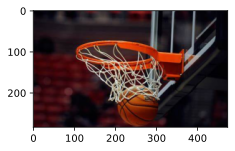

In [2]:
d2l.set_figsize()
img = d2l.Image.open('../imgs/ch14/OIP.jpg')
d2l.plt.imshow(img);

In [4]:
img.size

(474, 284)

In [7]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    '''Apply the transformation `aug` for `num_rows` x `num_cols` times
    and display all the results.
    
    Parameters
    ----------
    img : PIL.Image
        The image to apply the transformation.
    aug : class instance
        The transformation class instance.
    num_rows : int
        Number of rows for plotting.
    num_cols : int
        Number of columns for plotting.
    scale : float
        The scale of the output plot.
    '''
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

#### 14.1.1.1. Flipping and Cropping

Flipping the image left and right usually does not change the category of the object.

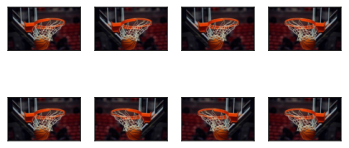

In [10]:
# Horizontal flip (left <-> right) with probability 0.5
apply(
    img,
    torchvision.transforms.RandomHorizontalFlip(), 
)

Flipping up and down is not as common as flipping left and right.

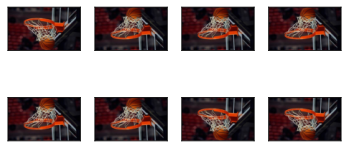

In [9]:
# Vertical flip (up <-> down) with probability 0.5
apply(
    img,
    torchvision.transforms.RandomVerticalFlip(), 
)

The main content of the image may not be located in the center of the image. We can also randomly crop the image to make objects appear in different positions in the image at different scales, which can reduce the sensitivity of a model to the target position.

In the example below, we randomly crop an area with an area of 10% to 100% of the original area each time, and the ratio of width to height of this area is randomly selected from 0.5 to 2. Then, the width and height of the region are both scaled to 200 pixels.

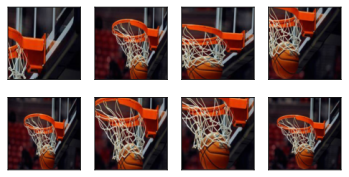

In [11]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), # output shape
    scale=(0.1, 1), # area range of the original image
    ratio=(0.5, 2) # aspect ratio range of the original image
)

apply(
    img,
    shape_aug,
)

#### 14.1.1.2. Changing Colors

To change colors, we can change 4 aspects of the image color: brightness, contrast, saturation, and hue. In the example below, we randomly change the brightness of the image to a value between 50% ($1-0.5$) and 150% ($1+0.5$) of the original image.

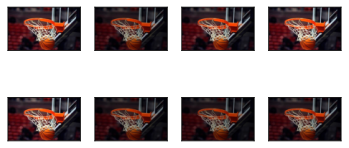

In [13]:
apply(
    img,
    torchvision.transforms.ColorJitter(
        brightness=0.5, # randomly change brightness with a factor in [0.5, 1.5]
        contrast=0,
        saturation=0,
        hue=0,
    )
)

Ranomly change the hue of the image

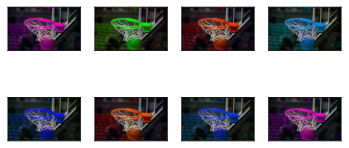

In [14]:
apply(
    img,
    torchvision.transforms.ColorJitter(
        brightness=0,
        contrast=0,
        saturation=0,
        hue=0.5, # randomly change hue with a factor in [0.5, 1.5]
    )
)

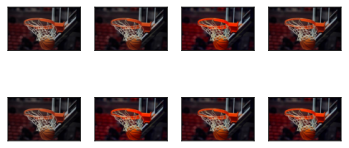

In [15]:
apply(
    img,
    torchvision.transforms.ColorJitter(
        brightness=0,
        contrast=0,
        saturation=0.5, # randomly change saturation with a factor in [0.5, 1.5]
        hue=0,
    )
)

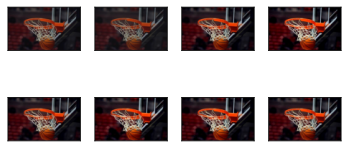

In [18]:
apply(
    img,
    torchvision.transforms.ColorJitter(
        brightness=0,
        contrast=0.5, # randomly change contrast with a factor in [0.5, 1.5]
        saturation=0,
        hue=0,
    )
)

We can also create a `ColorJitter` instance and set how to randomly change the `brightness`, `contrast`, `saturation`, and `hue` of the image at the same time.

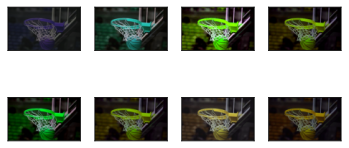

In [19]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5,
    contrast=0.5,
    saturation=0.5,
    hue=0.5,
)

apply(
    img,
    color_aug,
)

#### 14.1.1.3. Combining Multiple Image Augmentation Methods

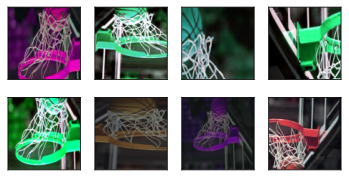

In [21]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    color_aug,
    shape_aug,
])

apply(
    img,
    augs,
)

### 14.1.2. Training with Image Augmentation

Use the CIFAR-10 dataset to demonstrate the effect of image augmentation on computer vision tasks.

Files already downloaded and verified


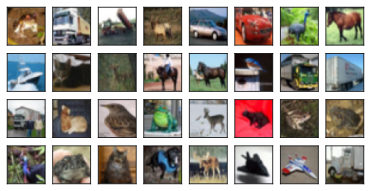

In [23]:
all_images = torchvision.datasets.CIFAR10(train=True,
                                          root="../data",
                                          download=True)

d2l.show_images(
    [all_images[i][0] for i in range(32)],
    4,
    8,
    scale=0.8,
);

In order to obtain definitive results during prediction, we usually only apply image augmentation to training examples, and do not use image augmentation with random operations during prediction.

The `ToTensor` instance is used to convert a minibatch of images into the format required by the deep learning framework, i.e., 32-bit floating point numbers between 0 and 1 with the shape of (batch_size, number of channels, height, width).

In [24]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [25]:
def load_cifar10(is_train, augs, batch_size):
    '''Load the CIFAR-10 dataset.
    
    Parameters
    ----------
    is_train : bool
        Whether to load the training set or the test set.
    augs : class instance
        The transformation class instance.
    batch_size : int
        The batch size of the data loader.
        
    Returns
    -------
    d2l.DataLoader
        The data loader.
    '''
    dataset = torchvision.datasets.CIFAR10(
        root="../data",
        train=is_train,
        transform=augs, # transformation
        download=True,
    )

    dataloader = torch.utils.data.DataLoader(
        dataset, # dataset
        batch_size=batch_size, # batch size
        shuffle=is_train, # shuffle
        num_workers=d2l.get_dataloader_workers(), # number of subprocesses for data loading
    )

    return dataloader

#### 14.1.2.1. GPU Training

In [28]:
def train_batch(net, X, y, loss, trainer, devices):
    '''Train for a minibatch with GPUs
    
    Parameters
    ----------
    net : torch.nn.Module
        The neural network.
    X : torch.Tensor
        The input tensor.
    y : torch.Tensor
        The ground truth tensor.
    loss : torch.nn.Module
        The loss function.
    trainer : torch.optim.Optimizer
        The optimizer.
    devices : list
        The list of GPUs.
        
    Returns
    -------
    train_loss_sum : torch.Tensor
        The sum of the training loss.
    train_acc_sum : torch.Tensor
        The sum of the training accuracy.
    '''
    if isinstance(X, list):
        # Required for BERT fine-tuning
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])

    y = y.to(devices[0])
    # Set the model in training mode
    net.train()
    # zero out gradients
    trainer.zero_grad()
    # forward pass
    pred = net(X)
    # compute loss
    l = loss(pred, y)
    # backward pass
    l.sum().backward()
    # update parameters
    trainer.step()

    # record the loss
    train_loss_sum = l.sum()
    # record the acc
    train_acc_sum = d2l.accuracy(pred, y)

    return train_loss_sum, train_acc_sum

In [29]:
def train(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
    '''Train a model with GPUs
    
    Parameters
    ----------
    net : torch.nn.Module
        The neural network.
    train_iter : d2l.DataLoader
        The training data loader.
    test_iter : d2l.DataLoader
        The test data loader.
    loss : torch.nn.Module
        The loss function.
    trainer : torch.optim.Optimizer
        The optimizer.
    num_epochs : int
        The number of epochs.
    devices : list
        The list of GPUs.
    '''
    timer = d2l.Timer()
    num_batches = len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0,1],
                            legend=['train loss', 'train acc', 'test acc'])
    
    # initialize the model on multiple GPUs
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])

    for epoch in range(num_epochs):
        # sum of training loss, sum of training accuracy, # of examples, # of predictions
        metric = d2l.Accumulator(4)

        for i, (features, labels) in enumerate(train_iter):
            timer.start()

            l, acc = train_batch(
                net, features, labels, loss, trainer, devices
            )
            metric.add(l, # sum of training loss
                       acc, # sum of training accuracy
                       labels.shape[0], # # of examples
                       labels.numel(), # # of predictions
                       )
            timer.stop()

            if (i+1) % (num_batches//5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i+1) / num_batches,
                    (metric[0] / metric[2], # avg training loss
                     metric[1] / metric[3], # avg training accuracy
                     None) # ignore for now
                )

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(
            epoch + 1,
            (None, 
                None,
            test_acc, # test accuracy
            )
        )

    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

The `train_with_data_aug` function is used to train the model with image augmentation.

In [31]:
batch_size = 256
devices = d2l.try_all_gpus()
net = d2l.resnet18(num_classes=10, in_channels=3)
net.apply(d2l.init_cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (resnet_block1): Sequential(
    (0): Residual(
      (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resnet_

In [32]:
def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    '''Train with data augmentation
    
    Parameters
    ----------
    train_augs : class instance
        The transformation class instance for training.
    test_augs : class instance
        The transformation class instance for testing.
    net : torch.nn.Module
        The neural network.
    lr : float
        The learning rate.
    '''
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)

    loss = nn.CrossEntropyLoss(reduction="none") # loss function (ignores reduction)

    trainer = torch.optim.Adam(net.parameters(), lr=lr)

    net(next(iter(train_iter))[0]) # initialize the model

    train(net, train_iter, test_iter, loss, trainer, 10, devices)

loss 0.201, train acc 0.931, test acc 0.842
344.6 examples/sec on [device(type='cuda', index=0)]


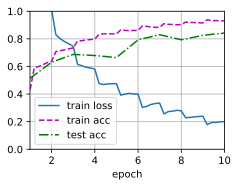

In [33]:
# train with data augmentation
train_with_data_aug(train_augs, test_augs, net)

## 14.2. Fine-Tuning

Suppose that we want to recognize different types of chairs from images, and then recommend purchase links to users. One possible method is to first identify 100 common chairs, take 1000 images of different angles for each chair, and then train a classification model on the collected image dataset. Although this chair dataset may be larger than the Fashion-MNIST dataset, the number of examples is still less than one-tenth of that in ImageNet. This may lead to overfitting of complicated models that are suitable for ImageNet on this chair dataset. Besides, due to the limited amount of training examples, the accuracy of the trained model may not meet practical requirements.

To address this issue, we can apply *transfer learning* to transfer the knowledge learned from the *source dataset* to the *target dataset*. For example, although most of the images in the ImageNet dataset have nothing to do with chairs, the model trained on this dataset may extract more general image features, which can help identify edges, textures, shapes, and object composition. These similar features may also be effective for recognizing chairs.

### 14.2.1. Steps

One common technique in transfer learning is *fine-tuning*. As shown in the figure below, fine-tuning consists of the following four steps:
1. Pretrain a neural network model, i.e., the *source model*, on the source dataset (e.g., the ImageNet dataset).
2. Create a new neural network model, i.e., the *target model*. This copies all model designs and their parameters on the source model except the output layer. Assume that the model parameters contain the knoeledge learned from the source dataset and this knowledge will also be applicable to the target dataset. Also assume that the output layer of the source model is closely related to the labels of the source dataset; thus it is not used in the target model.
3. Add an output layer to the target model, whose number of outputs is the number of categories in the target dataset. Then randomly initialize the model parameters of this layer.
4. Train the target model on the target dataset, such as the chair dataset. The output layer will be trained from scratch, while the parameters of all the other layers are fine-tuned based on the parameters of the source model.

![](../imgs/ch14/finetune.svg)

When target datasets are much smaller than source datasets, fine-tuning helps to improve models' generalization ability.

### 14.2.2. Hot Dog Recognition

We will fine-tune a ResNet model on a small dataset, which was pretrained on ImageNet dataset.

In [1]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn

from d2l import torch as d2l

#### 14.2.2.1. Reading the Dataset

The hog dog dataset contains 1400 positive-class images containing hot dogs, and as many negative-class images containing other foods. 1000 images of both classes are used for training and the rest are used for testing.

In [2]:
# download the dataset
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                          'fba480ffa8aa7e0febbb511d181409f899b9baa5')
data_dir = d2l.download_extract('hotdog')

In [3]:
data_dir

'../data\\hotdog'

In [4]:
# create training and test datasets
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

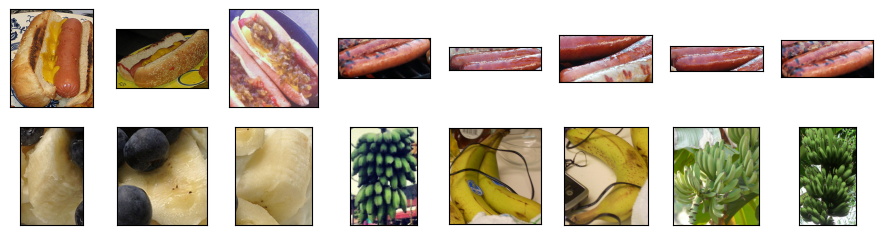

In [5]:
num_examples = 8
hotdogs = [train_imgs[i][0] for i in range(num_examples)]
not_hotdogs = [train_imgs[-i-1][0] for i in range(num_examples)]

d2l.show_images(hotdogs + not_hotdogs, 2, num_examples, scale=1.4);

During training,
1. crop a random area of random size and random aspect ratio from the image,
2. scale this area to a $224 \times 224$ input image.

During testing,
1. scale both the height and width of an image to 256 pixels,
2. crop a central $224 \times 224$ area as input.

For the three RGB color channels, we *standardize* their values channel by channel.

In [6]:
# specify the means and standard deviations of the three RGB channels 
# to standardize the image channel
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], # mean
    [0.229, 0.224, 0.225] # std
)

# training augmentation
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224), # resize and crop
    torchvision.transforms.RandomHorizontalFlip(), # flip horizontally
    torchvision.transforms.ToTensor(), # to tensor
    normalize, # normalize
])

# test augmentation
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]), # resize
    torchvision.transforms.CenterCrop(224), # center crop
    torchvision.transforms.ToTensor(), # to tensor
    normalize, # normalize
])

#### 14.2.2.2. Defining and Initializing the Model

We use ResNet-18, which was pretrained on the ImageNet dataset, as the source model.

In [8]:
# load resnet18 weights
from torchvision.models import ResNet18_Weights
weights = ResNet18_Weights.DEFAULT

In [9]:
pretrained_net = torchvision.models.resnet18(weights=weights)

The pretrained source model instance contains a number of feature layers and an output layer `fc`. The member variable `fc` of source model is given below:

In [10]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

As a fully connected layer, it transforms ResNet’s final global average pooling outputs into 1000 class outputs of the ImageNet dataset. We then construct a new neural network as the target model. It is defined in the same way as the pretrained source model except that its number of outputs in the final layer is set to the number of classes in the target dataset (rather than 1000).

In the target model, the model parameters before the output layer of the target model instance `finetune_net` are initialized to model parameters of the corresponding layers from the source model. These model parameters were obtained via pretraining on ImageNet, and we can only use a small learning rate to ***fine-tune*** such pretrained parameters. In contrast, model parameters in the output layer are randomly initialized and generally require a larger learning rate to be learned from scratch.

Letting the base learning rate be $\eta$, a learning rate of $10\eta$ will be used to iterate the model parameters in the output layer.

In [11]:
# initialize a target network
finetune_net = torchvision.models.resnet18(weights=weights)
# replace the output layer
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, # input size
                            2, # output size
                            )
# initialize the fc layer
nn.init.xavier_uniform_(finetune_net.fc.weight)

Parameter containing:
tensor([[ 0.0204, -0.0412,  0.0935,  ...,  0.0323, -0.0698, -0.0960],
        [ 0.0662, -0.0130, -0.0192,  ..., -0.0923, -0.0629,  0.0137]],
       requires_grad=True)

#### 14.2.2.3. Fine-Tuning the Model

First, we define a training function `train_fine_tuning` that uses fine-tuning so it can be called multiple times.

In [12]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, params_group=True):
    '''Fine-tune a model
    
    Parameters
    ----------
    net : torch.nn.Module
        The neural network.
    learning_rate : float
        The learning rate.
    batch_size : int
        The batch size.
    num_epochs : int
        The number of epochs.
    params_group : bool
        If `param_group is True`, the model parameters in the output layer will be
        updated using a learning rate 10 times greater than `learning_rate`. Default is True.
    '''
    # load data batches
    train_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                         transform=train_augs),
        batch_size=batch_size,
        shuffle=True,
    )
    test_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'),
                                         transform=test_augs),
        batch_size=batch_size,
        shuffle=False,
    )
    # check devices
    devices = d2l.try_all_gpus()
    # loss function
    loss = nn.CrossEntropyLoss(reduction="none")

    if params_group:
        params_1x = [param for name, param in net.named_parameters()
                     if name not in ['fc.weight', 'fc.bias']]
        
        trainer = torch.optim.SGD(
            [
                {'params': params_1x}, # learning rate 1x
                {'params': net.fc.parameters(), 'lr': learning_rate * 10}, # learning rate 10x
            ],
            lr=learning_rate, # global learning rate
            weight_decay=0.001, # weight decay
        )
    else:
        trainer = torch.optim.SGD(
            net.parameters(),
            lr=learning_rate,
            weight_decay=0.001,
        )

    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

We set the base learning rate to a small value in order to *fine-tune* the model parameters obtained via pretraining. Based on the previous settings, we will train the output layer parameters of the target model from scratch using a learning rate ten times greater.

loss 0.226, train acc 0.923, test acc 0.910
91.1 examples/sec on [device(type='cuda', index=0)]


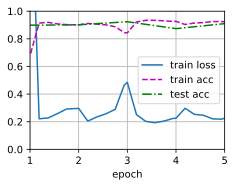

In [13]:
train_fine_tuning(finetune_net, learning_rate=5e-5)

We also define an identical model but initialize all of its model parameters to random values. Since it is trained from scratch, we will use a greater learning rate.

loss 0.378, train acc 0.834, test acc 0.843
99.7 examples/sec on [device(type='cuda', index=0)]


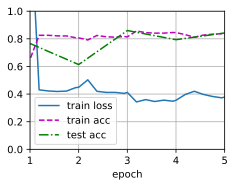

In [14]:
scratch_net = torchvision.models.resnet18()
# replace the output layer
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)

train_fine_tuning(scratch_net, # train from scratch
                  learning_rate=5e-4, # learning rate
                  params_group=False, # do not use different learning rates
                  )

As we can see, the fine-tuned model tends to perform better for the same epoch because its initial parameter values are more effective.

## 14.3. Object Detection

In image classification tasks, we assume that there is only *one major object* in the image and we only focus on how to recognize its category.

The *object detection* (or *object recognition*) is to identify multiple objects of various categories in the image and indicate their categories and locations with *bounding boxes*.

In [31]:
%matplotlib inline
import torch

from d2l import torch as d2l

(2460, 4200, 3)

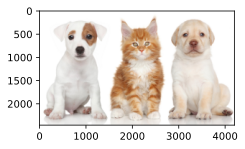

In [35]:
d2l.set_figsize()
# read the image
img = d2l.plt.imread('../imgs/ch14/catdogs.jpg')
d2l.plt.imshow(img);
img.shape

### 14.3.1. Bounding Boxes

In object detection, we usually use a *bounding box* to describe the spatial location of an object. 

The bounding box is a rectangular box, which is determined by 
1. the $x$ and $y$ coordinates of the upper-left corner of the rectangle and the $x$ and $y$ coordinates of the lower-right corner, or
2. the $(x,y)$ coordinates of the center of the rectangle, and the width and height of the rectangle.

The functions below convert between these two representations.

In [17]:
def box_corner_to_center(boxes):
    '''Convert from (upper-left, bottom-right) to (center, width, height)'''
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]

    # center
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    # width
    w = x2 - x1
    # height
    h = y2 - y1

    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    '''Convert from (center, width, height) to (upper-left, bottom-right)'''
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]

    # upper-left
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    # bottom-right
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h

    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

The origin of the coordinates in the image is the upper-left corner of the image, and to the right and down are the positive directions of the $x$ and $y$ axes, respectively.

In [48]:
dog1_bbox = [60.0, 105.0, 1500.0, 2350.0]
dog2_bbox = [1550.0, 112.0, 2655.0, 2411.0]
cat_bbox = [2750.0, 160.0, 4120.0, 2311.0]

Verify the correctness of the bounding box conversion functions by converting twice:

In [49]:
boxes = torch.tensor((dog1_bbox, dog2_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]])

In [50]:
def bbox_to_rect(bbox, color):
    '''Convert bounding box to matplotlib format'''
    # convert the bounding box (upper-left x, upper-left y, bottom-right x, bottom-right y) format
    # to matplotlib format: ((upper-left x, upper-left y), width, height)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), # upper-left
        width=bbox[2] - bbox[0], # width
        height=bbox[3] - bbox[1], # height
        fill=False, # no fill
        edgecolor=color, # color
        linewidth=2, # line width
    )

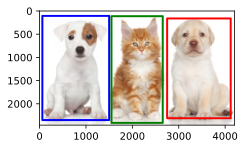

In [51]:
fig = d2l.plt.imshow(img)

# draw bounding boxes
fig.axes.add_patch(bbox_to_rect(dog1_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(dog2_bbox, 'green'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

Object detection not only recognizes all the objects of interest in the image, but also their positions. The position is generally represented by a rectangular bounding box.

## 14.4. Anchor Boxes

Object detection algorithms usually sample a large number of regions in the input image, determine whether these regions contain objects of interest, and adjust the boundaries of the regions so as to predict the *ground-truth bounding boxes* of the objects more accurately.

One of the method to adopt different region sampling schemes is to generate multiple bounding boxes with varying scales and aspect ratios centered on each pixel. These bounding boxes are called *anchor boxes*.

In [1]:
%matplotlib inline
import torch

from d2l import torch as d2l

# simplify printing accuracy
torch.set_printoptions(2)

### 14.4.1. Generating Multiple Anchor Boxes

Suppose that the input image has a height of $h$ and width of $w$. We generate anchor boxes with different shapes centered on each pixel of the image.

Let the *scale* of $s\in (0,1]$ and the *aspect ratio* (ratio of width to height) is $r>0$. Then, the width and height of the anchor box are $ws\sqrt{r}$ and $hs/\sqrt{r}$, respectively. When the center position is given, an anchor box with known width and height is determined.

To generate multiple anchor boxes with different shapes, we set a series of scales $s_1,\ldots,s_n$ and a series of aspect ratios $r_1,\ldots,r_m$. When using all the combinations of these scales and aspect ratios with each pixel as the center, the input image will have a total of $whnm$ anchor boxes. Although these anchor boxes may cover all the ground-truth bounding boxes, the computational complexity is too high.

In practice, we can only consider those combinations containing $s_1$ or $r_1$:
\begin{split}
(s_1, r_1), (s_1, r_2), \ldots, (s_1, r_m), (s_2, r_1), (s_3, r_1), \ldots, (s_n, r_1).
\end{split}
That is, the number of anchor boxes centered on the same pixel is $n+m-1$. For the entire input iamge, we will generate a total of $wh(n+m-1)$ anchor boxes.

In [2]:
def multibox_prior(data, sizes, ratios):
    '''Generate anchor boxes with different shapes centered on each pixel
    
    Parameters
    ----------
    data : torch.Tensor
        The input tensor with shape (batch size, # channels, height, width).
    sizes : list
        The list of scales of anchor boxes.
    ratios : list
        The list of aspect ratios of anchor boxes.
        
    Returns
    -------
    anchors : torch.Tensor
        The anchor boxes with shape (batch size, # anchors, 4).
    '''
    # height and width of the input tensor
    in_height, in_width = data.shape[-2:]

    device = data.device
    num_sizes = len(sizes) # number of scales
    num_ratios = len(ratios) # number of aspect ratios

    boxes_per_pixel = num_sizes + num_ratios - 1 # number of anchor boxes per pixel
    size_tensor = torch.tensor(sizes, device=device) # scale tensor
    ratio_tensor = torch.tensor(ratios, device=device) # aspect ratio tensor

    # Offsets are required to move the anchor to the center of a pixel.
    # Since a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height # scaled steps in y axis
    steps_w = 1.0 / in_width # scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1) # flatten

    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = torch.cat(
        (size_tensor * torch.sqrt(ratio_tensor[0]), # first ratio in each scale 
         sizes[0] * torch.sqrt(ratio_tensor[1:])), # first scale in each ratio
    ) * in_height / in_width # handle rectangular inputs
    h = torch.cat(
        (size_tensor / torch.sqrt(ratio_tensor[0]), # first ratio in each scale
         sizes[0] / torch.sqrt(ratio_tensor[1:])), # first scale in each ratio
    )

    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack(
        (-w, -h, w, h)
    ).T.repeat(in_height * in_width, 1) / 2

    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    out_grid = torch.stack(
        [shift_x, shift_y, shift_x, shift_y],
        dim=1
    ).repeat_interleave(boxes_per_pixel, dim=0)

    anchors = out_grid + anchor_manipulations # add center point and anchor box offsets
    return anchors.unsqueeze(0) # add batch dimension

In [3]:
img = d2l.plt.imread('../imgs/ch14/catdogs.jpg')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w)) # construct input tensor
scales = [0.75, 0.5, 0.25] # scales of anchor boxes
ratios = [1, 2, 0.5] # aspect ratios of anchor boxes
Y = multibox_prior(X, sizes=scales, ratios=ratios)
Y.shape

2460 4200


torch.Size([1, 51660000, 4])

In [4]:
# check the number of anchor boxes per pixel
h * w * (len(scales) + len(ratios) - 1)

51660000

After changing the shape of the anchor box variable `Y` to (image height, image width, number of anchor boxes centered on the same pixel, 4), we can obtain all the anchor boxes centered on a specified pixel position.

In [5]:
boxes = Y.reshape(h, # height
                  w, # width
                  5, # number of anchor boxes per pixel
                  4, # number of coordinates per anchor box
                )

We can access the first anchor box centered on (2000, 1250), which has four elements: the $(x,y)$-axis coordinates at the upper-left corner and the $(x,y)$-axis coordinates at the lower-right corner of the anchor box. The coordinate values of both axes are divided by the width and height of the image, respectively. Note that the coordinates of the upper-left corner of the image are (0, 0), so the xy coordinates of (2000, 1250) should be stored as [1250, 2000] in the anchor box.

In [6]:
boxes[1250, # anchor box center y
      2000, # anchor box center x
      0, # first anchor box
      :, # all coordinates
      ]

tensor([0.26, 0.13, 0.70, 0.88])

In [7]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    '''Show bounding boxes
    
    Parameters
    ----------
    axes : matplotlib axes
        The axes to show the bounding boxes.
    bboxes : torch.Tensor
        The bounding boxes.
    labels : list
        The list of labels.
    colors : list
        The list of colors.
    '''

    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    
    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])

    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        
        axes.add_patch(rect)

        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], # upper-left x
                      rect.xy[1], # upper-left y
                      labels[i], # label
                      va='center', # vertical alignment
                      ha='center', # horizontal alignment
                      fontsize=9, # font size
                      color=text_color, # font color
                      bbox=dict(facecolor=color, lw=0), # background color
                      )

The coordinate values of the $x$ and $y$ are in the variable `boxes` have been divided by the width and height of the image, respectively. When drawing anchor boxes, we need to restore their original coordinate values; thus, we define variable `bbox_scale`.

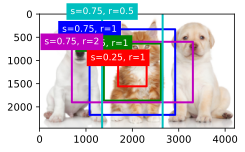

In [8]:
d2l.set_figsize()

bbox_scale = torch.tensor((w, h, w, h))

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes,
            boxes[1250, 2000, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2', 's=0.75, r=0.5'],
            )

### 14.4.2. Intersection of Union (IoU)

The *Jaccard index* can measure the similarity between two sets. Given sets $\mathcal{A}$ and $\mathcal{B}$, their Jaccard index is the size of their intersection divided by the size of their union:
\begin{split}
J(\mathcal{A},\mathcal{B}) = \frac{\left|\mathcal{A} \cap \mathcal{B}\right|}{\left| \mathcal{A} \cup \mathcal{B}\right|}.
\end{split}

We can consider the pixel area of any bounding box as a set of pixels. Then we can measure the similarity of the two bounding boxes by the Jaccard index of their pixel sets. For two bounding boxes, we usually refer their Jaccard index as *intersection over union (IoU)*, which is the ratio of their intersection area to their union area, as shown in the figure below.

![](../imgs/ch14/iou.svg)

The range of an IoU is between 0 and 1: 0 means that two bounding boxes do not overlap at all, while 1 indicates that two bounding boxes are completely the same.

In [9]:
def box_iou(boxes1, boxes2):
    '''Compute pairwise IoU across two lists of anchor or bounding boxes'''
    box_area = lambda boxes: (
        (boxes[:, 2] - boxes[:, 0]) * # width
        (boxes[:, 3] - boxes[:, 1]) # height
    )

    # Shape of `boxes1`, `boxes2`, `areas1`, `areas2`:
    # (number of boxes1, 4), (number of boxes2, 4), (number of boxes1,), (number of boxes2,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)

    # Shape of `inter_upperlefts`, `inter_lowerrights`, `inters`:
    # (number of boxes1, number of boxes2, 2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2]) # add None in the second axis to expand boxes1
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0) # intersection

    # Shape of `inter_areas` and `union_areas`: (number of boxes1, number of boxes2)
    inter_areas = inters[:, :, 0] * inters[:, :, 1] # width * height
    union_areas = areas1[:, None] + areas2 - inter_areas # union = area1 + area2 - intersection

    iou = inter_areas / union_areas

    return iou

### 14.4.3. Labeling Anchor Boxes in Training Data

In a training dataset, each anchor box is considered as a training example. To train an object detection model, we need *class labels*, which are the classes of the object relevant to the anchor box, and *offset labels*, are the offset of the ground-truth bounding box relative to the anchor box, for each anchor box.

During the prediction, for each image we generate multiple anchor boxes, predict classes and offsets for all the anchor boxes, adjust their positions based on the predicted offsets to obtain the predicted bounding boxes, and finally only output those predicted bounding boxes that satisfy certain criteria.

#### 14.4.3.1. Assigning Ground-Truth Bounding Boxes to Anchor Boxes

Given an image, suppose that the anchor boxes are $A_1, A_2, \ldots, A_{n_a}$, and the ground-truth bounding boxes are $B_1, B_2, \ldots, B_{n_b}$, where $n_a \geq n_b$. 

Suppose to define a matrix $\mathbf{X}\in \mathbb{R}^{n_a \times n_b}$, whose element $x_{ij}$ in the $i$-th row and $j$-th column is the IoU of the anchor box $A_i$ and the ground-truth bounding box $B_j$. 

The algorithm for assigning closest ground-truth bounding boxes for anchor boxes is as follows:
1. Find the largest element in matrix $\mathbf{X}$ and denote its row and column indices as $i_1$ and $j_1$, respectively. Then the ground-truth bounding box $B_{j_1}$ is assigned to the anchor box $A_{i_1}$, since $A_{i_1}$ and $B_{j_1}$ are the closest among all the pairs of anchor boxes and ground-truth bounding boxes. After the first assignment, discard all the elements in the $i_1$-th row and $j_1$-th column in matrix $\mathbf{X}$.
2. Find the largest of the remaining elements in matrix $\mathbf{X}$ and denote its row and column indices as $i_2$ and $j_2$, respectively. Then the ground-truth bounding box $B_{j_2}$ is assigned to the anchor box $A_{i_2}$, and then we discard all the elements in the $i_2$-th row and $j_2$-th column in matrix $\mathbf{X}$.
3. Proceed in this way until all elements in $n_b$ columns in matrix $\mathbf{X}$ are discarded. At this point, we have assigned each ground-truth bounding box to each of $n_b$ anchor boxes.
4. Only traverse through the remaining $n_a-n_b$ anchor boxes. Given any anchor box $A_i$, find the ground-truth bounding box $B_j$ with the largest IoU with $A_i$ throughout the $i$th row of matrix $\mathbf{X}$, and assign $B_j$ to $A_i$ only if this IoU is greater than a predefined threshold.


For example, in the left figure below, assuming that the maximum IoU value in matrix $\mathbf{X}$ is $x_{23}$, we assign the ground-truth bounding box $B_3$ to the anchor box $A_2$. Then we discard all the elements in row 2 and column 3 of the matrix. Next, we find the largest $x_{71}$ in the remaining matrix (shaded area), assign the ground-truth bounding box $B_1$ to the anchor box $A_7$, and discard all elements in row 7 and column 1. (middle figure). Next, we find the largest $x_{54}$ in the remaining matrix (shaded area), assign the ground-truth bounding box $B_4$ to the anchor box $A_5$, and discard all elements in row 5 and column 4 (right figure). Finally we find the largest $x_{92}$ in the remaining matrix (shaded area), assign the ground-truth bounding box $B_2$ to the anchor box $A_9$. After that, we have assigned all ground-truth bounding boxes, and we only need to traverse through the remaining anchor boxes $A_1, A_3, A_4, A_6, A_8$ and determine whether to assign them gorund-truth bounding boxes based on the IoU threshold.

![](../imgs/ch14/anchor-label.svg)

In [10]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    '''Assign the ground truth bounding boxes to anchor boxes'''
    num_anchors = anchors.shape[0] # number of anchor boxes
    num_gt_boxes = ground_truth.shape[0] # number of ground truth bounding boxes

    # Element x_ij in the i-th row and j-th column is 
    # the IoU of the anchor box i and the ground-truth bounding box j
    jaccard = box_iou(anchors, ground_truth)

    # Initialize the tensor to hold the assigned ground truth bounding box for each anchor
    anchors_bbox_map = torch.full(
        (num_anchors,), # shape
        -1, # fill value
        dtype=torch.long, # data type
        device=device, # device
    )

    # Assign ground-truth bounding boxes according to the threshold
    max_ious, indices = torch.max(jaccard, dim=1) # max IoU and its index for each anchor box
    # indices of anchor boxes whose max IoU is greater than or equal to the threshold
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1) # return indices of nonzero elements
    # indices of ground truth bounding boxes whose max IoU is greater than or equal to the threshold
    box_j = indices[max_ious >= iou_threshold]
    # assign ground truth bounding boxes to anchor boxes
    anchors_bbox_map[anc_i] = box_j

    # prepare discard rows and columns used later
    col_discard = torch.full(
        (num_anchors,), # shape
        -1, # fill value
    )
    row_discard = torch.full(
        (num_gt_boxes,), # shape
        -1, # fill value
    )

    # Repeat the process of assigning ground truth bounding boxes to anchor boxes
    for _ in range(num_gt_boxes):
        # Find the largest IoU
        max_idx = torch.argmax(jaccard)
        # Get the index of the ground truth bounding box
        box_idx = (max_idx % num_gt_boxes).long()
        # Get the index of the anchor box
        anc_idx = (max_idx // num_gt_boxes).long()
        # Assign the ground truth bounding box to the anchor box
        anchors_bbox_map[anc_idx] = box_idx
        # Discard the row and column corresponding to the anchor box or ground truth bounding box
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard

    return anchors_bbox_map

#### 14.4.3.2. Labeling Classes and Offsets

Suppose that an anchor box $A$ is assgined a ground-truth bounding box $B$. The class of the anchor box $A$ will be labeled as that of $B$, and the offset of the anchor box $A$ will be labeled according to the relative position between the central coordinates of $B$ and $A$ together with the relative size between these two boxes.

Given the central coordinates of $A$ and $B$ as $(x_a, y_a)$ and $(x_b, y_b)$, their widths as $w_a$ and $w_b$, and their heights as $h_a$ and $h_b$, respectively, the offset of $A$ can be labeled as
\begin{split}
\left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x},
\frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right),
\end{split}
where default values of the constants are $\mu_x = \mu_y = \mu_w = \mu_h = 0$ and $\sigma_x = \sigma_y =0.1$, and $\sigma_w = \sigma_h = 0.2$.

In [11]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    '''Transform for anchor box offsets'''
    # anchor box center coordinates
    c_anc = d2l.box_corner_to_center(anchors)
    # ground truth bounding box center coordinates
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    # offset in center coordinates
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    # offset in width and height
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    # stack the offsets
    offset = torch.cat((offset_xy, offset_wh), axis=1)

    return offset

If an anchor box is not assigned a ground-truth bounding box, we just label the class of the anchor box as “background”. Anchor boxes whose classes are background are often referred to as *negative anchor boxes*, and the rest are called *positive anchor boxes*. 

In [12]:
def multibox_target(anchors, labels):
    '''Label anchor boxes with ground truth bounding boxes'''
    batch_size = labels.shape[0] # batch size
    # delete the first dimension
    anchors = anchors.squeeze(0)

    batch_offset, batch_mask, batch_class_labels = [], [], []

    device = anchors.device
    num_anchors = anchors.shape[0] # number of anchor boxes

    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)

        # initialize class labels and assigned bounding box coordinates with zeros
        class_labels = torch.zeros(num_anchors, dtype=torch.long, device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device)

        # Label classes of anchor boxes using their assigned ground truth bounding boxes.
        # If an anchor box is not assigned any, 
        # we label its class as background (the value remains zero)
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]

        # offset transformation
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)

    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)

    return (bbox_offset, bbox_mask, class_labels)

The `multibox_target` function will label classes and offsets for anchor boxes `anchor` using ground-truth bounding boxes `label`. This function also sets the background class to zero and increments the integer index of a new class by one.

#### 14.4.3.3. An Example

We define ground-truth bounding boxes for the dogs and cat in the loaded images, where the 1st element is the class (0 for dog and 1 for cat) and the remaining four elements are the $(x,y)$-axis coordinates at the upper-left corner and the lower-right corner (range is between 0 and 1).

We also construct 5 anchor boxes to be labeled using the coordinates of the upper-left and lower-right corners: $A_0,\ldots,A_4$. 

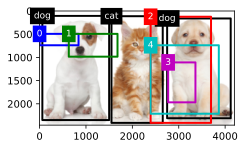

In [21]:
# ground truth bounding boxes from previous section
ground_truth = torch.tensor([
    [0, 60.0, 105.0, 1500.0, 2350.0],
    [0, 1550.0, 112.0, 2655.0, 2411.0],
    [1, 2750.0, 160.0, 4120.0, 2311.0]
])
# normalize the ground truth bounding boxes
ground_truth[:, 1] /= 4200
ground_truth[:, 2] /= 2460
ground_truth[:, 3] /= 4200
ground_truth[:, 4] /= 2460

# anchor boxes
anchors = torch.tensor([
    [0, 0.2, 0.2, 0.3], 
    [0.15, 0.2, 0.4, 0.4],
    [0.57, 0.05, 0.88, 0.98], 
    [0.66, 0.45, 0.8, 0.8],
    [0.57, 0.3, 0.92, 0.9]
])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat', 'dog'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

Using the `multibox_target` function, we can label classes and offsets of these anchor boxes based on the ground-truth bounding boxes for the dogs and cat. In this example, the indices of the background, dog, and cat classes are 0, 1, and 2, respectively.

In [14]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))
labels # (offset, mask, class labels)

(tensor([[-0.00, -0.00, -0.00, -0.00, -3.57,  9.95,  1.58,  7.59,  3.00, -0.14,
           0.25, -0.31, -0.00, -0.00, -0.00, -0.00, -6.98, -1.45, -1.43,  2.22]]),
 tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
          1., 1.]]),
 tensor([[0, 1, 2, 0, 1]]))

The last item in the returned item `lablels` is the class label for each anchor box:

In [15]:
labels[2]

tensor([[0, 1, 2, 0, 1]])

The 2nd returned item is a mask variable of the shape (batch size, 4x number of anchor boxes). Every 4 elements in the mask variable correspond to the 4 offset values of each anchor box. Since we do not care about background detection, offsets of this negative class should not affect the objective function. Through elementwise multiplications, zeros in the mask variable will filter out negative class offsets before calculating the objective function.

In [16]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

The 1st returned item contains the 4 offset values labeled for each anchor box. The offsets of negative-class anchor boxes are labeled as zeros.

In [17]:
labels[0]

tensor([[-0.00, -0.00, -0.00, -0.00, -3.57,  9.95,  1.58,  7.59,  3.00, -0.14,
          0.25, -0.31, -0.00, -0.00, -0.00, -0.00, -6.98, -1.45, -1.43,  2.22]])

### 14.4.4. Predicting Bounding Boxes with Non-Maximum Suppression

During prediction phase, we generate multiple anchor boxes for the image and predict classes and offsets for each of them.

A *predicted bounding box* is obtained according to an anchor box with its predicted offset.

In [18]:
def offset_inverse(anchors, offset_preds):
    '''Predict bounding boxes based on anchor boxes with predicted offsets'''
    anc = d2l.box_corner_to_center(anchors)

    # predicted center
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    # predicted width and height
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    # stack the predicted center coordinates and width and height
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    # convert to bounding box corners
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)

    return predicted_bbox

The `offset_inverse` function takes in anchors and offset predictions as inputs and applies inverse offset transformations to return the predicted bounding box coordinates.

To simplify the outputs of many similar predicted bounding boxes for surrounding the same object, we can merge similar predicted bounding boxes that belong to the same object by using *non-maximum suppression* (NMS).

(**Non-Maximum Suppression**) For a predicted bounding box $B$, the object detection model calculates the predicted likelihood for each class. Denoting by $p$ the largest predicted likelihood, the class corresponding to this probability is the predicted class for $B$. We refer to $p$ as the *confidence* (score) of the predicted bounding box $B$. On the same image, all the predicted non-background bounding boxes are sorted by confidence in descending order to generate a list $L$, and we can manipulate the sorted list $L$:
1. to select the predicted bounding box $B_1$ with the highest confidence from $L$ as a basis and remove all non-basis predicted bounding boxes whose IoU with $B_1$ exceeds a predefined threshold $\epsilon$ from $L$. Now $L$ keeps the predicted bounding box with the highest confidence but drops others that are too similar to it. In a nutshell, those with *non-maximum* confidence scores are *suppressed*.
2. to select the predicted bounding box $B_2$ with the 2nd highest confidence from $L$ as another basis and remove all non-basis predicted bounding boxes whose IoU with $B_2$ exceeds $\epsilon$ from $L$.
3. to repeat the above process until all the predicted bounding boxes in $L$ have been used as a basis. At this time, the IoU of any pair of predicted bounding boxes in $L$ is below the threshold $\epsilon$; thus, no pair is too similar with each other.
4. to output all the predicted bounding boxes in the list $L$.

In [26]:
def nms(boxes, scores, iou_threshold):
    '''Sort confidence scores of predicted bounding boxes'''
    B = torch.argsort(scores, dim=-1, descending=True) # sort confidence scores
    keep = [] # indices of predicted bounding boxes to keep

    while B.numel() > 0:
        i = B[0] # index of the bounding box with the highest confidence score
        keep.append(i)

        if B.numel() == 1: break

        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]

    return torch.tensor(keep, device=boxes.device)

The `multibox_detection` function applies non-maximum suppression to predict bounding boxes.

In [29]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5, pos_threshold=0.00999999):
    '''Predict bounding boxes using non-maximum suppression'''
    device = cls_probs.device
    batch_size = cls_probs.shape[0] # batch size

    anchors = anchors.squeeze(0) # delete the first dimension
    num_classes = cls_probs.shape[1]
    num_anchors = cls_probs.shape[2]
    out = []

    for i in range(batch_size):
        cls_prob = cls_probs[i]
        offset_pred = offset_preds[i].reshape(-1, 4)

        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        
        keep = nms(predicted_bb, conf, nms_threshold)
        # Find all non-`keep` indices and set the class to background
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]

        # `pos_threshold` is a threshold for positive (non-background) predictions
        below_min_idx = conf < pos_threshold
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat(
            (class_id.unsqueeze(dim=1), conf.unsqueeze(dim=1), predicted_bb),
            dim=1,
        )

        out.append(pred_info)

    return torch.stack(out)

In [23]:
# predicted anchor boxes
anchors = torch.tensor([
    [0, 0.2, 0.2, 0.3], 
    [0.15, 0.2, 0.4, 0.4],
    [0.57, 0.05, 0.88, 0.98], 
    [0.66, 0.45, 0.8, 0.8],
    [0.57, 0.3, 0.92, 0.9]
])
# predicted offsets
offset_preds = torch.tensor([0] * anchors.numel())
# predicted class probabilities
cls_probs = torch.tensor([
    [0] * 5, # predicted background likelihood
    [0.9, 0.8, 0.7, 0.1, 0.2], # predicted likelihoods of dog
    [0.1, 0.2, 0.3, 0.9, 0.8], # predicted likelihoods of cat
])

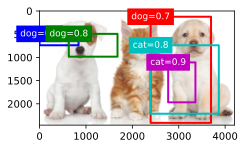

In [24]:
fig = d2l.plt.imshow(img)

show_bboxes(fig.axes,
            anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9', 'cat=0.8'])

To perform non-maximum suppression, we can invoke the `multibox_detection` function where the threshold is set to 0.5. We also need to add a dimension for examples in the tensor input.

In [30]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.00,  0.90,  0.00,  0.20,  0.20,  0.30],
         [ 1.00,  0.90,  0.66,  0.45,  0.80,  0.80],
         [ 0.00,  0.80,  0.15,  0.20,  0.40,  0.40],
         [ 1.00,  0.80,  0.57,  0.30,  0.92,  0.90],
         [-1.00,  0.70,  0.57,  0.05,  0.88,  0.98]]])

The shape of the returned result is (batch size, number of anchor boxes, 6). The 6 elements in the innormost dimension gives the output information for the same predicted bounding box:
* the 1st element is the predicted class index, which starts from 0 (0 is dog and 1 is cat). The value -1 indicates background or removal in non-maximum suppression.
* the 2nd element is the confidence of the predicted bounding box.
* the remaining 4 elements are the $(x,y)$-axis coordinates at the upper-left corner and the lower-right corner of the predicted bounding box, respectively (range is between 0 and 1).


We can output the final predicted bounding box keep by non-maximum suppression:

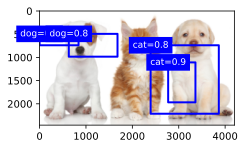

In [32]:
fig = d2l.plt.imshow(img)

for i in output[0].detach().numpy():
    if i[0] == -1: continue

    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

In practice, we can remove predicted bounding boxes with lower confidence even before performing non-maximum suppression, thereby reducing computation in this algorithm. We may also post-process the output of non-maximum suppression, for example, by only keeping results with higher confidence in the final output.

## 14.5. Multiscale Object Detection

The anchor boxes we generated in the previous section represent samples of different regions of the image, but the number of anchor boxes to compute may blow up for every pixel. For example, if we generate 5 anchor boxes on each of the $2460\times 4200$ pixels of the image, we will be able to obtain a total of $2460 \times 4200 \times 5 = 51,660,000$ anchor boxes.

### 14.5.1. Multiscale Anchor Boxes

To reduce the number of anchor boxes, we can uniformly sample a small portion of pixels from the input image to generate anchor boxes centered on them. In addition, at different scales we can generate different numbers of anchor boxes of different sizes. Intuitively, smaller objects are more likely to appear on an image than larger ones.

In [1]:
%matplotlib inline
import torch

from d2l import torch as d2l

In [2]:
img = d2l.plt.imread('../imgs/ch14/catdogs.jpg')
h,w = img.shape[:2]
h,w

(2460, 4200)

In CNNs, a 2D array output of a convolutional layer is called a *feature map*. By defining the feature map shape, we can determine centers of uniformly sampled anchor boxes on any image.

In [3]:
def display_anchors(fmap_w, fmap_h, s):
    d2l.set_figsize()
    # Values on the first two dimensions do not affect the output
    fmap = torch.zeros((1, 10, fmap_h, fmap_w)) # feature map shape (batch size, # channels, height, width)
    anchors = d2l.multibox_prior(fmap, # feature map
                                 sizes=s, # scales of anchor boxes
                                 ratios=[1, 2, 0.5] # aspect ratios of anchor boxes
                                )
    bbox_scale = torch.tensor((w, h, w, h))

    d2l.show_bboxes(d2l.plt.imshow(img).axes,
                    anchors[0] * bbox_scale)

The `display_anchors` function generates anchor boxes (`anchors`) on the feature map (`fmap`) with each unit (pixel) as the anchor box center. Since the $(x,y)$-axis coordinate values in the anchor boxes (`anchors`) have been divided by the width and height of the faeture map (`fmap`), these values are between 0 and 1, which indicate the relative positions of anchor boxes in the feature map.

Since centers of the anchor boxes (`anchors`) are spread over all units on the feature map (`fmap`), these centers must be *uniformly* distributed on any input image in terms of their relative spatial positions. Given the width and height of the feature map `fmap_w` and `fmap_h`, respectively, the `display_anchors` function will *uniformly* sample pixels in `fmap_h` rows and `fmap_w` columns on any input image. Centered on these uniformly sampled pixels, anchor boxes of scale `s` (assuming the length of the list `s` is 1) and different aspect ratios (`ratios`) are generated.

In order to make the detection of small objects easier to distinguish when displayed, the anchor boxes with different centers here do not overlap: the anchor box scale `s` is set to 0.15 and the height `fmap_h` and width `fmap_w` of the feature map are set to 4:

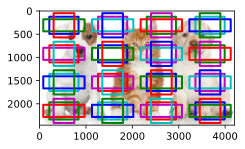

In [8]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

We now reduce the height and width of the feature map by half and use larger anchor boxes to detect larger objects. When the scale is set to 0.4, some anchor boxes will overlap with each other:

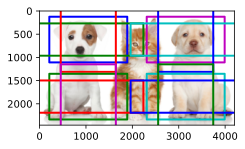

In [5]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

We further reduce the height and width of the feature map by half and increase the scale to 0.8. Now the center of the anchor box is the center of the image:

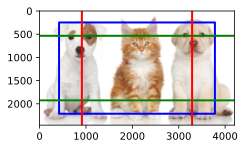

In [6]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

### 14.5.2. Multiscale Detection

After generating multiple anchor boxes, we can use them to detect objects of various sizes at different scales.

Assume that we have $c$ feature maps of shape $h\times w$. Using the the multiscale anchor boxes, we generate $hw$ sets of anchor boxes, where each set has $a$ anchor boxes with the same center. For example, at the fist scale in the experiments above, given 10 (number of channels) $4\times 4$ feature maps, we generated 16 sets of anchor boxes, where each set contains 3 anchor boxes with the same center.

Next, each anchor box is labeled with the class and offset based on ground-truth bounding boxes. At the current scale, the object detection model needs to predict the classes and offsets of $hw$ sets of anchor boxes on the input image, where different sets have different centers.

Assume that the $c$ feature maps are the intermediate outputs obtained by the CNN forward propagation based on the input image. Since there are $hw$ different spatial positions on ecah feature map, the same spatial position can be thought of as having $c$ units. According to the definition of receptive field in Chapter 7, these $c$ units at the same spatial position of the feature maps have the same receptive field on the input image: they represent the input image information in the same receptive field. Therefore, we can transform the $c$ units of the feature maps at the same spatial position into the classes and offsets of the $a$ anchor boxes generated using this spatial position.

When the feature maps at different layers have varying-size receptive fields on the input image, they can be used to detect objects of different sizes.

## 14.6. The Object Detection Dataset

### 14.6.1. Downloading the Dataset

In [9]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision

from d2l import torch as d2l

In [10]:
# download the dataset
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

### 14.6.2. Reading the Dataset

In [11]:
def read_data_bananas(is_train=True):
    '''Read the banana detection dataset images and labels'''
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir,
                             'bananas_train' if is_train else 'bananas_val',
                             'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')

    images, targets = [],[]
    for img_name, target in csv_data.iterrows():
        images.append(
            torchvision.io.read_image(
                os.path.join(data_dir,
                             'bananas_train' if is_train else 'bananas_val',
                             'images', 
                             f'{img_name}')
            )
        )
        # `target` contains (class, upper-left x, upper-left y, lower-right x, lower-right y),
        # where all the image have the same banana class (index 0)
        targets.append(list(target))

    return images, torch.tensor(targets).unsqueeze(1) / 256

The banana dataset includes a csv file for object class labels and ground-truth bounding box coordinates at the upper-left and lower-right corners.

In [12]:
class BananaDataset(torch.utils.data.Dataset):
    '''Customized dataset to load the banana detection dataset'''
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('Read ' + str(len(self.features)) + (f' training examples' if
                                                   is_train else f' validation examples'))
        
    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])
    
    def __len__(self):
        return len(self.features)

In [13]:
def load_data_bananas(batch_size):
    '''Load the banana detection dataset'''
    train_iter = torch.utils.data.DataLoader(BananaDataset(is_train=True),
                                             batch_size,
                                             shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananaDataset(is_train=False),
                                           batch_size)
    
    return train_iter, val_iter

* The shape of the image minibatch is (batch size, number of channels, height, width).
* The shape of the label minibatch is (batch size, $m$, 5), where $m$ is the largest possible number of bounding boxes that any image has in the dataset.

Images may have a varying number of bounding boxes; thus, images with fewer than $m$ bounding boxes will be paded with illegal bounding boxes until $m$ is reached. Then the label of each bounding box is represented by an array of length 5. The first element in the array is the class of the object in the bounding box, where -1 indicates an illegal bounding box for padding. The next four elements are the $(x,y)$-coordinate values of the upper-left corner and the lower-right corner of the bounding box (the range is between 0 and 1).

For the banana dataset, since there is only one bounding box on each image, we have $m=1$.

In [14]:
# batch size
batch_size = 32
# image edge size
edge_size = 256

train_iter, _ = load_data_bananas(batch_size=batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

Read 1000 training examples
Read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

### 14.6.3. Demonstration

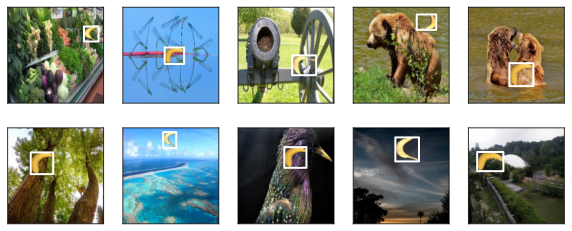

In [15]:
imgs = batch[0][:10] # first 10 images
# change to (batch size, height, width, # channels) and normalize
imgs = imgs.permute(0, 2, 3, 1) / 255 

axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][:10]):
    # draw bounding box
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

## 14.7. Single Shot Multibox Detection

### 14.7.1. Model

![](../imgs/ch14/ssd.svg)

The figure above provides an overview of the design of single-shot multibox detection. The model consists of a base network block followed by several multiscale feature map blocks. 

The base network block is used to extract features from the input image, so it can use a deep CNN. The original single-shot multibox detection paper adopts a VGG network truncated before the classification layer, while ResNet has also been commonly used. We make cake the base network output larger feature maps so as to generate more anchor boxes for detecting smaller objects.

Each multiscale feature map block reduces the height and width of the feature maps from the previous block, and enables each unit of the feature maps to increase its receptive field on the input image.

Since multiscale feature maps closer to the top layer of the base network are smaller but have larger receptive fields, they are suitable for detecting fewer but larger objects.

In summary, via its base network and several multiscale feature map blocks, single-shot multibox detection generates a varying number of anchor boxes with different sizes, and detects varying-size objects by predicting classes and offsets of these anchor boxes (thus the bounding boxes); thus, this is a multiscale object detection model.

#### 14.7.1.1. Class Prediction Layer

Let the number of object classes be $q$. Then anchor boxes have $q+1$ classes, where 0 is background. At some scale, suppose that the height and width of feature maps are $h$ and $w$, respectively. When $a$ anchor boxes are generated with each spatial position of these feature maps as their center, a total of $hwa$ anchor boxes need to be classified.

To reduce model complexity at the class prediction layer, the class prediction layer uses a convolutional layer without altering width and height of feature maps. Thus, there can be a one-to-one correspondence between outputs and inputs at the same spatial dimensions (width and height) of feature maps. The channels of the output feature maps at any spatial position $(x,y)$ represent class predictions for all the anchor boxes centered on $(x,y)$ of the input feature maps. To produce valid predictions, there must be $a(q+1)$ output channels, where for the same spatial position the output channel with index $i(q+1)+j$ represents the prediction of the class $j(0 \leq j \leq q)$ for the anchor box $i(0 \leq i \leq a)$.

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F

from d2l import torch as d2l

We can define a class prediction layer specifying $a$ and $q$ via arguments `num_anchors` and `num_classes`, respectively. This layer uses a $3\times 3$ convolutional layer with a padding of 1. The width and height of the input and output of this convolutional layer remain unchanged.

In [2]:
def class_predictor(num_inputs, num_anchors, num_classes):
    '''Class prediction block'''
    out = nn.Conv2d(
        num_inputs, # input channels
        num_anchors * (num_classes + 1), # output channels
        kernel_size=3, # kernel size
        padding=1, # padding
    )

    return out

#### 14.7.1.2. Bounding Box Prediction Layer

Similar to the class prediction layer, the bounding box prediction layer also uses a convolutional layer but with a different number of output channels. Here we need to predict 4 offsets rather than $q+1$ classes for each anchor box. Since we need to predict 4 offsets for each anchor box, the number of output channels is $4a$.

In [3]:
def bbox_predictor(num_inputs, num_anchors):
    '''Bounding box prediction block'''
    out = nn.Conv2d(
        num_inputs, # input channels
        num_anchors * 4, # output channels
        kernel_size=3, # kernel size
        padding=1, # padding
    )

    return out

#### 14.7.1.3. Concatenating Predictions for Multiple Scales

Single-shot multibox detection uses multiscale feature maps to generate anchor boxes and predict their classes and offsets. At different scales, the shapes of feature maps or the number of anchor boxes centered on the same unit may vary. Therefore, shapes of the prediction outputs at different scales may vary.

We now construct feature maps at two different scales, `Y1` and `Y2`, for the same minibatch, where the height and width of `Y2` are half of those of `Y1`.

Suppose that 5 and 3 anchor boxes are generated for every unit in `Y1` and `Y2`, respectively. Suppose further that the number of object classes is 10. For feature maps `Y1` and `Y2`, the number of channels in the class prediction outputs are $5\times (10+1)=55$ and $3\times (10+1)=33$, respectively, where either output shape is (batch size, number of channels, height, width).

In [4]:
def forward(x, block):
    return block(x)

In [5]:
Y1 = forward(torch.zeros((2, 8, 20, 20)),
             class_predictor(num_inputs=8, num_anchors=5, num_classes=10))
Y1.shape

torch.Size([2, 55, 20, 20])

In [6]:
Y2 = forward(torch.zeros((2, 16, 10, 10)),
             class_predictor(num_inputs=16, num_anchors=3, num_classes=10))
Y2.shape

torch.Size([2, 33, 10, 10])

Except for the batch size, the other three dimensions all have different sizes. To concatenate these two prediction outputs for more efficient computation, we will transform these tensors into a more consistent format.

The channel dimension holds the predictions for anchor boxes with the same center. We first move this dimension to the innermost. Since the batch size remains the same for different scales, we can transform the prediction output into a 2D tensor with shape (batch size, height $\times$ width $\times$ number of channels). Then we can concatenate such outputs at different scales along dimension 1.

In [7]:
def flatten_pred(pred):
    '''Flatten the prediction tensor'''
    # change to (batch size, height, width, # channels)
    out = pred.permute(0, 2, 3, 1) 
    # flatten the tensor to (batch size, height * width * # channels)
    out = torch.flatten(out, start_dim=1)

    return out

def concat_preds(preds):
    '''Concatenate multiple prediction tensors'''
    outs = [flatten_pred(p) for p in preds] # flatten
    # concatenate on the last dimension
    outs = torch.cat(outs, dim=1)

    return outs

In this way, even though `Y1` and `Y2` have different sizes in channels, heights, and widths, we can still concatenate these two prediction outputs at two different scales for the same minibatch.

In [8]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

In [9]:
torch.flatten(Y1, start_dim=1).shape, torch.flatten(Y2, start_dim=1).shape

(torch.Size([2, 22000]), torch.Size([2, 3300]))

#### 14.7.1.4. Downsampling Block

In order to detect objects at multiple scales, we define the downsampling block `down_sample_blk` that halves the height and width of input feature maps. This block consists of two $3\times 3$ convolutional layers with a padding of 1 followed by a $2\times 2$ max-pooling layer with a stride of 2. The $3\times 3$ convolutional layers with padding of 1 do not change the shape of feature maps, but the subsequent $2\times 2$ max-pooling reduces the height and width of input feature maps by half.

For both input and output feature maps of this downsampling block, because $1\times 2+(3-1)+(3-1)=6$, each unit in the output has a $6\times 6$ receptive field on the input. Therefore, the downsampling block enlarges the receptive field of each unit in its output feature maps.

In [10]:
def down_sample_blk(in_channels, out_channels):
    '''Down-sampling block'''
    blk = []

    for _ in range(2): # 2 convolutional layers
        # 3 x 3 convolutional layer
        blk.append(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        # batch normalization
        blk.append(nn.BatchNorm2d(out_channels))
        # ReLU activation
        blk.append(nn.ReLU())
        in_channels = out_channels

    # 2 x 2 maximum pooling layer
    blk.append(nn.MaxPool2d(kernel_size=2, stride=2))

    return nn.Sequential(*blk)

In [11]:
in_feature_maps = torch.zeros((2, 3, 20, 20))
forward(in_feature_maps, down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

Our constructed downsampling block changes the number of input channels and halves the height and width of the input feature maps.

#### 14.7.1.5. Base Network Block

The base network block is used to extract features from input images.

For simplicity, we construct a small base network block consisting of 3 downsampling blocks that double the number of channels at each block. Given a $256\times 256$ input image, this base network block outputs $32\times 32$ feature maps ($256/2/2/2=32$).

In [12]:
def base_net():
    '''Base network'''
    blk = []
    num_filters = [3, 16, 32, 64] # number of convolutional filters

    for i in range(len(num_filters) - 1):
        blk.append(
            down_sample_blk(num_filters[i], num_filters[i + 1])
        )

    return nn.Sequential(*blk)

In [13]:
input_images = torch.zeros((2, 3, 256, 256))
forward(input_images, base_net()).shape

torch.Size([2, 64, 32, 32])

#### 14.7.1.6. The Complete Model

The complete single shot multibox detection model consists of five blocks. The feature maps produced by each block are used for both
1. generating anchor boxes and
2. predicting classes and offsets of these anchor boxes.

Inside the complete model, the first block is the base network block, the second to the fourth blocks are downsampling blocks, and the last block uses global max-pooling to reduce both the height and width to 1.

In [14]:
def get_blk(i):
    if i == 0:
        # base network
        blk = base_net()
    elif i == 1:
        # first down-sampling block
        blk = down_sample_blk(64, 128)
    elif i == 4:
        # last global maximum pooling layer
        blk = nn.AdaptiveMaxPool2d((1, 1))
    else:
        # rest of the down-sampling blocks
        blk = down_sample_blk(128, 128)

    return blk

For the forward propagation, the outputs include
1. CNN feature maps `Y`,
2. anchor boxes generated using `Y` at the current scale, and 
3. classes and offsets predicted (based on `Y`) for these anchor boxes.

In [15]:
def blk_forward(X, blk, size, ratio, class_predictor, bbox_predictor):
    # feature maps of the block
    Y = blk(X)
    # generate anchor boxes
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    # predicted classes
    class_preds = class_predictor(Y)
    # predicted bounding boxes
    bbox_preds = bbox_predictor(Y)

    return (Y, anchors, class_preds, bbox_preds)

Recall that a multiscale feature map block that is closer to the top is for detecting larger objects; thus, it needs to generate larger anchor boxes. In the above forward propagation, at each multiscale feature map block, we pass in a list of two scale values via the `sizes` argument of the invoked `multibox_prior` function. In the following, the interval between 0.2 and 1.05 is split evenly into five sections to determine the smaller scale values at the five blocks: 0.2, 0.37, 0.54, 0.71, and 0.88. Then their larger scale values are given by 
* $\sqrt{0.2 \times 0.37}=0.272$, 
* $\sqrt{0.37 \times 0.54}=0.447$, 
* $\sqrt{0.54 \times 0.71}=0.608$, 
* $\sqrt{0.71 \times 0.88}=0.776$, and 
* $\sqrt{0.88 \times 1.05}=0.935$, respectively. 

In [16]:
sizes = [
    [0.2, 0.272], 
    [0.37, 0.447], 
    [0.54, 0.619],
    [0.71, 0.79], 
    [0.88, 0.961],
]
ratios = [
    [1, 2, 0.5]
] * 5

num_anchors = len(sizes[0]) + len(ratios[0]) - 1

The complete model `TinySSD` is defined below.

In [17]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes

        self.idx_to_in_channels = [64, 128, 128, 128, 128]

        for i in range(len(self.idx_to_in_channels)):
            # equivalent to the assignment statement `self.blk_i = get_blk(i)`
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'class_{i}', class_predictor(self.idx_to_in_channels[i],
                                                        num_anchors,
                                                        num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(self.idx_to_in_channels[i],
                                                      num_anchors))
            
    def forward(self, X):
        # prepare predicted anchor boxes and predicted classes and bounding boxes
        anchors, class_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5

        for i in range(len(self.idx_to_in_channels)):
            # `getattr(self, f'blk_{i})` accesses `self.blk_i`
            X, anchors[i], class_preds[i], bbox_preds[i] = blk_forward(
                X,
                getattr(self, f'blk_{i}'),
                sizes[i],
                ratios[i],
                getattr(self, f'class_{i}'),
                getattr(self, f'bbox_{i}'),
            )

        anchors = torch.cat(anchors, dim=1)
        class_preds = concat_preds(class_preds)
        # reshape predicted classes to (batch size, number of anchor boxes, number of classes)
        class_preds = class_preds.reshape(class_preds.shape[0], -1, self.num_classes+1)
        bbox_preds = concat_preds(bbox_preds)

        return anchors, class_preds, bbox_preds

In [18]:
batch_size = 32
edge_size = 256

X = torch.zeros((batch_size, 3, edge_size, edge_size))

# create a model instance
net = TinySSD(num_classes=1)
# forward computation
anchors, class_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', class_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


The first block (base network block) outputs $32\times 32$ feature maps. The second to the fourth downsampling blocks halve the height nad width and the fifth block uses global pooling. Since 4 anchor boxes are generated for each unit along spatial dimensions of feature maps, at all the five scales, a total of $(32^2 + 16^2 + 8^2 + 4^2 + 1)\times 4 = 5444$ anchor boxes are generated for each image.

### 14.7.2. Training

#### 14.7.2.1. Reading the Dataset and Initializing the Model

In [19]:
batch_size = 32

train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


There is only one class in the banana detection dataset. After defining the model, we need to initialize its parameters and define the optimization algorithm.

In [20]:
# create a model instance
net = TinySSD(num_classes=1)
# find the device
device = d2l.try_gpu()

# create a trainer
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

#### 14.7.2.2. Defining Loss and Evaluation Functions

Object detection has two types of losses.
* The first loss concerns classes of anchor boxes: its computation can simply resue the cross-entropy loss function.
* The second loss concerns offsets of positive (non-background) anchor boxes: this is a regression problem. Here we do not use the squared loss but the $\ell_1$ norm loss, the absolute value of the difference between the prediction and the ground-truth. The mask variable `bbox_masks` filters out negative anchor boxes and illegal (padded) anchor boxes in the loss calculation.

Finally, we sum up the anchor box class loss and the anchor box offset loss to obtain the loss function for the model.

In [21]:
# class loss
class_loss = nn.CrossEntropyLoss(reduction='none')
# bounding box loss
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(class_preds, class_labels, bbox_preds, bbox_labels, bbox_masks):
    # shape of `class_preds`: (batch size, number of anchor boxes, number of classes)
    batch_size = class_preds.shape[0]
    num_classes = class_preds.shape[2]

    val_class_loss = class_loss(
        class_preds.reshape(-1, num_classes), # shape: (batch size * number of anchor boxes, number of classes)
        class_labels.reshape(-1), # shape: (batch size * number of anchor boxes,)
    )
    # reshape to (batch size, number of anchor boxes)
    val_class_loss = val_class_loss.reshape(batch_size, -1)
    # reduction: sum over all anchor boxes
    val_class_loss = val_class_loss.mean(dim=1)\
    # shape of `val_class_loss`: (batch size,)

    val_bbox_loss = bbox_loss(
        bbox_preds * bbox_masks, # apply mask to ignore padding boxes
        bbox_labels * bbox_masks, # apply mask to ignore padding boxes
    )# shape: (batch size, number of anchor boxes * 4)
    # reducetion: sum over the classes
    val_bbox_loss = val_bbox_loss.sum(dim=1)
    # shape of `val_bbox_loss`: (batch size,)

    return val_class_loss + val_bbox_loss

We can use accuracy to evaluate the classification results.

Due to the used $\ell_1$ norm loss for the offsets, we use the *mean absolute error* (MAE) to evaluate the predicted bounding boxes. These prediction results are obtained from the generated anchor boxes and the predicted offsets for them.

In [22]:
def class_eval(class_preds, class_labels):
    # Because the class prediction results are on the final dimension,
    # `argmax` needs to specify this dimension
    class_preds = class_preds.argmax(dim=-1).type(class_labels.dtype)
    # compare the predicted and ground truth classes
    res = class_preds == class_labels
    # sum the results and convert to float
    res = float(res.sum())

    return res

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    res = torch.abs((bbox_labels - bbox_preds) * bbox_masks)
    # sum the results and convert to float
    res = float(res.sum())

    return res

#### 14.7.2.3. Training the Model

When training the model, we need to generate multiscale anchor boxes (`anchors`) and predict their classes (`cls_preds`) and offsets (`box_preds`) in the forward propagation. Then we label the classes (`clas_labels`) and offsets (`bbox_labels`) of such generated anchor boxes based on the label information `Y`. Finally, we calculate the loss function using the predicted and labeled values of the classes and offsets.

Class Error 4.85e-03, Bounding Box mae 4.20e-03
3534.1 examples/sec on cuda:0


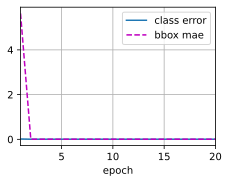

In [23]:
num_epochs = 20
timer = d2l.Timer()
animator = d2l.Animator(xlabel='epoch', 
                        xlim=[1, num_epochs], 
                        legend=['class error', 'bbox mae'])

net.to(device)

for epoch in range(num_epochs):
    # We store 4 items in `metric`:
    # sum of training accuracy, no. of examples in sum of training accuracy,
    # sum of absolute error, and no. of examples in sum of absolute error
    metric = d2l.Accumulator(4)
    net.train()

    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()

        X, Y = features.to(device), target.to(device)

        # Generate multiscale anchor boxes and predict their classes and offsets
        anchors, class_preds, bbox_preds = net(X)
        # Label the classes and offsets of these anchor boxes
        bbox_labels, bbox_masks, class_labels = d2l.multibox_target(anchors, Y)
        # Calculate the loss function using the predicted and labeled values
        # of the classes and offsets
        l = calc_loss(class_preds, class_labels, bbox_preds, bbox_labels, bbox_masks)
        # Calculate the gradients
        l.mean().backward()
        # Update the model parameters
        trainer.step()

        # record metrics
        metric.add(
            class_eval(class_preds, class_labels), # sum of training accuracy
            class_labels.numel(), # no. of examples in sum of training accuracy
            bbox_eval(bbox_preds, bbox_labels, bbox_masks), # sum of absolute error
            bbox_labels.numel(), # no. of examples in sum of absolute error
        )

    # class error
    class_error = 1 - metric[0] / metric[1]
    # bounding box mae
    bbox_mae = metric[2] / metric[3]
    # add to animator
    animator.add(epoch + 1, # x-axis,
                 (class_error, bbox_mae)) # y-axis
    
print(f'Class Error {class_error:.2e}, Bounding Box mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on {str(device)}')

### 14.7.3. Prediction

During prediction, the goal is to detect all the objects of interest on the image.

In [24]:
X = torchvision.io.read_image('../imgs/ch14/banana.jpg')
X.shape

torch.Size([3, 256, 256])

We need to convert the test image to a 4D tensor that is required by convolutional layers.

In [25]:
X = X.unsqueeze(0).float()
X.shape

torch.Size([1, 3, 256, 256])

In [26]:
# prepare the image for display
# change to (height, width, # channels)
img = X.squeeze(0).permute(1, 2, 0).long()
img.shape

torch.Size([256, 256, 3])

The `predict` function predicts the bounding boxes obtained from the anchor boxes and their predicted offsets. Then we use non-maximum suppression to remove similar bounding boxes.

In [34]:
def predict(X):
    net.eval()

    anchors, class_preds, bbox_preds = net(X.to(device))
    class_probs = F.softmax(class_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(class_probs, bbox_preds, anchors)

    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)
output.shape

torch.Size([283, 6])

In [35]:
output

tensor([[ 0.0000,  0.2328,  0.0584,  0.1187,  0.9313,  0.9683],
        [ 0.0000,  0.0841,  0.5110,  0.5393,  1.2195,  1.2173],
        [ 0.0000,  0.0740, -0.1489,  0.3845,  0.3875,  1.3573],
        ...,
        [ 0.0000,  0.0125,  0.5786, -0.1048,  1.1208,  0.1596],
        [ 0.0000,  0.0124,  0.1014,  0.3988,  1.1951,  0.8963],
        [ 0.0000,  0.0105,  0.2490,  0.0487,  1.0065,  0.6873]],
       device='cuda:0', grad_fn=<IndexBackward0>)

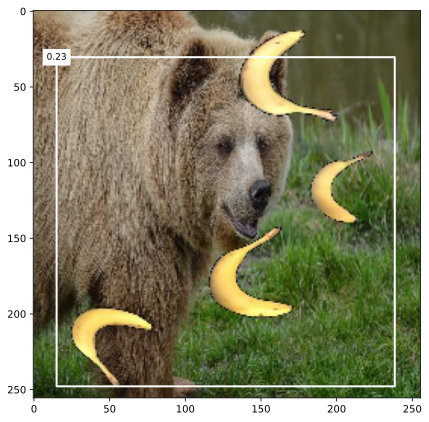

In [38]:
# display all predicted bounding boxes with confidence >= 0.9
def display(img, output, threshold):
    d2l.set_figsize((7,7))
    fig = d2l.plt.imshow(img)

    for row in output:
        score = float(row[1])
        if score < threshold: continue

        h, w = img.shape[:2]
        # display predicted bounding box
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.1)

The $\ell_1$ norm loss used in the training model is not necessarily the best choice for the prediction model. For example, we replace $\ell_1$ norm loss with smooth $\ell_1$ norm loss for the predicted offsets. The smooth $\ell_1$ norm loss function uses a square function around zero for smoothness, which is controlled by a hyperparameter $\sigma$:
\begin{split}f(x) =
    \begin{cases}
    (\sigma x)^2/2,& \textrm{if }|x| < 1/\sigma^2\\
    |x|-0.5/\sigma^2,& \textrm{otherwise}
\end{cases}\end{split}

When $\sigma$ is very large, this loss is similar to the $\ell_1$ norm loss. When its value is smaller, the loss function is smoother.

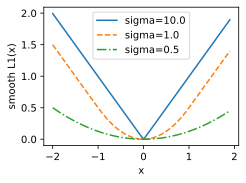

In [45]:
def smooth_l1(data, scalar):
    out = []
    for i in data:
        if abs(i) < 1 / (scalar ** 2):
            out.append(((scalar * i) ** 2) / 2)
        else:
            out.append(abs(i) - 0.5 / (scalar ** 2))
    return torch.tensor(out)

sigmas = [10, 1, 0.5]
lines = ['-', '--', '-.']
x = torch.arange(-2, 2, 0.1)
d2l.set_figsize()

for l, s in zip(lines, sigmas):
    y = smooth_l1(x, scalar=s)
    d2l.plt.plot(x, y,
                 l,
                 label='sigma=%.1f' % s)
d2l.plt.xlabel('x')
d2l.plt.ylabel('smooth L1(x)')
d2l.plt.legend();

In this experiment we use cross-entropy for class prediction: denoting by $p_j$ the predicted probability for the ground-truth class $j$, the cross-entropy is $-\log p_j$. Here we can also use the focal loss: given hyperparameter $\gamma > 0$ and $\alpha >0$, the focal loss is defined as:
\begin{split}
\textrm{Focal Loss} = - \alpha (1-p_j)^{\gamma} \log p_j
\end{split}

Increasing $\gamma$ can effectively reduce the relative loss for well-classified examples (e.g., $p_j > 0.5$) so the training can focus more on those difficult examples that are misclassified.

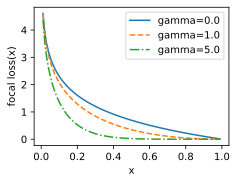

In [46]:
def focal_loss(gamma, x):
    return -(1 - x) ** gamma * torch.log(x)

d2l.set_figsize()
x = torch.arange(0.01, 1, 0.01)
for l, gamma in zip(lines, [0, 1, 5]):
    y = d2l.plt.plot(x, focal_loss(gamma, x), l, label='gamma=%.1f' % gamma)
d2l.plt.xlabel('x')
d2l.plt.ylabel('focal loss(x)')
d2l.plt.legend();

## 14.8. Region-based CNNs (R-CNNs)

Besides SSD, region-based CNNs or regions with CNN features (R-CNNs) are also among many pioneering approaches of applying deep learning to object detection.

### 14.8.1. R-CNNs

The *R-CNN* first extracts many *region proposals* from the input image (e.g., anchor boxes can also be considered as region proposals), labeling their classes and bounding boxes (e.g., offsets).

Then, a CNN is used to perform forward propagation on each region proposal to extract its features. Next, features of each region proposal are used to predict the class and bounding box of this region proposal.

![](../imgs/ch14/r-cnn.svg)

The figure above shows the design of the R-CNN model. The R-CNN consists of 4 steps:
1. Perform *selective search* to extract multiple high-quality region proposals on the input image. These proposed regions are usually selected at multiple scales with different shapes and sizes. Each region proposal will be labeled with a class and a ground-truth bounding box.
2. Choose a pretrained CNN and truncate it before the output layer. Resize each region proposal to the input size required by the network, and output the extracted features for the region proposal through forward propagation.
3. Take the extracted features and labeled class of each region proposal as an example. Train multiple support vector machines to classify objects, where each support vector machine individually determines whether the example contains a specific class.
4. Take the extracted features and labeled bounding box of each region proposal as an example. Train a linear regression model to predict the ground-truth bounding box.

Although the R-CNN model uses pretrained CNNs to effectively extract image features, it is slow. If we want to select thousands of region proposals from a single input, this requires thousands of forward propagations of the CNN to perform object detection.

### 14.8.2. Fast R-CNN

The main performance bottleneck of an R-CNN lies in the independent CNN forward propagation for each region proposal, without sharing computation. Since these regions usually have overlaps, independent feature extractions lead to much repeated computation.

![](../imgs/ch14/fast-rcnn.svg)

The figure above describes the fast R-CNN model. It has the following steps:
1. Compared with the R-CNN, in the fast R-CNN the input of the CNN for feature extraction is the entire image, rather than individual region proposals. Moreover, this CNN is trainable. Given an input image, let the shape of the CNN output be $1\times c \times h_1 \times w_1$.
2. Suppose that selective search generates $n$ region proposals. These region proposals (of different shapes) mark regions of interest (of different shapes) on the CNN output. Then these regions of interest further extract features of the same shape (say, height $h_2$ and width $w_2$) in order to be easily concatenated.  To achieve this, the fast R-CNN introduces the *region of interest (ROI) pooling layer*: the CNN output and region proposals are input into this layer, outputting concatenated features of shape $n\times c \times h_2 \times w_2$ that are further extracted for all the region proposals.
3. Using a fully connected layer, transform the concatenated features into an output of shape $n\times d$, where $d$ depends on the model design.
4. Predict the class and bounding box for each of the $n$ region proposals. In class and bounding box prediction, transform the fully connected layer output into an output of shape $n\times q$ ($q$ is the number of classes) and an output of shape $n\times 4$, respectively. The class prediction uses softmax regression.

In the regular pooling layer, we indirectly control the output shape by specifying sizes of the pooling window, padding, and stride. In the region of interest pooling layer, we directly specify the output shape. For example, we can specify the output height and width for each region as $h_2$ and $w_2$, respectively. For any region of interest window of shape $h \times w$, this window is divdied into a $h_2\times w_2$ grid of subwindows, where the shape of each subwindow is approximately $h/h_2 \times w/w_2$. In practice, the height and width of any subwindow shall be rounded up, and the largest element shall be used as output of the subwindow. Therefore, the region of interest pooling layer can extract features of the same shape even when regions of interest have different shapes.

![](../imgs/ch14/roi.svg)

As shown in the figure above, the upper-left $3\times 3$ region of interest is selected on a $4\times 4$ input. For this region of interest, we use a $2\times 2$ region of interest pooling layer to obtain a $2\times 2$ output. Each of the four divided subwindows contains elements:
* 0, 1, 4, and 5 (5 is the maximum) for the upper-left subwindow,
* 2 and 6 (6 is the maximum) for the upper-right subwindow,
* 8 and 9 (9 is the maximum) for the lower-left subwindow, and
* 10 (the maximum) for the lower-right subwindow.

In [1]:
import torch
import torchvision

Suppose that the height and width of the CNN-extracted feature `X` are both 4, and there is only a single channel:

In [11]:
X = torch.arange(16.).reshape(1,1,4,4) # shape: (batch size, # channels, height, width)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

Further suppose that the height and width of the input image are both 40 pixels and that selective search generates two region proposals on this image. Each region proposal is expressed as five elements:
* its object class and 
* the $(x,y)$-coordinates of its upper-left and lower-right corners.

In [12]:
rois = torch.tensor(
    [[0, 0, 0, 20, 20],
    [0, 0, 10, 30, 30]]
)
rois = rois.float()
rois

tensor([[ 0.,  0.,  0., 20., 20.],
        [ 0.,  0., 10., 30., 30.]])

Because the height and width of `X` are 1/10 of the height and width of the input image, the coordinates of the two region proposals are multiplied by 1/10 according to the specified `spatial_scale` argument. Then the two regions of interest are marked on `X` as `X[:, :, 0:3, 0:3]` and `X[:, :, 1:4, 0:4]`, respectively.

Finally in the $2\times 2$ region of interest pooling, each region of interest is divided into a grid of sub-windows to further extract features of the same shape $2\times 2$.

In [13]:
torchvision.ops.roi_pool(
    X, # input
    rois, # region of interest
    output_size=(2, 2), # output size
    spatial_scale=0.1, # scale
)

tensor([[[[ 5.,  6.],
          [ 9., 10.]]],


        [[[ 9., 11.],
          [13., 15.]]]])

### 14.8.3. Faster R-CNN

To be more accurate in object detection, the fast R-CNN model usually has to generate a lot of region proposals in selective search. To reduce region proposals without loss of accuracy, the *faster R-CNN* proposes to replace selective search with a *region proposal network*.

![](../imgs/ch14/faster-rcnn.svg)

The figure above shows the faster R-CNN model. The faster R-CNN only changes the region proposal method from select search to a region proposal network. The rest of the model design is the same as the fast R-CNN.

The region proposal network:
1. uses a $3\times 3$ convolutional layer with padding of 1 to transform the CNN output to a new output with $c$ channels. Then each unit along the spatial dimensions of the CNN-extracted feature maps gets a new feature vector of length $c$.
2. centered on each pixel of the feature maps, generates multiple anchor boxes of different scales and aspect ratios and labels them.
3. using the length-$c$ feature vector at the center of each anchor box, predicts the binary class (background or objects) and bounding box for this anchor box.
4. considers those predicted bounding boxes whose predicted classes are objects. Remove To be more accurate in object detection, the fast R-CNN model usually has to generate a lot of region proposals in selective search. To reduce region proposals without loss of accuracy, the faster R-CNN proposes to replace selective search with a region proposal network.

As part of the faster R-CNN model, the region proposal network is jointly trained with the rest of the model. The objective function of the faster R-CNN includes not only the class and bounding box predcition in object detection, but also the binary class and bounding box prediction of anchor boxes in the region proposal network.

As a result of the end-to-end training, the region proposal network learns how to generate high-quality region proposals, so as to stay accurate in object detection with a reduced number of region proposals that are learned from data.

### 14.8.4. Mask R-CNN

In the training dataset, if pixel-level positions of object are also labeled on images, the *mask R-CNN* can effectively leverage such detailed labels to further improve the accuracy of object detection.

![](../imgs/ch14/mask-rcnn.svg)

As shown in the figure above, the mask R-CNN is modified based on the faster R-CNN. The mask R-CNN replaces the region of interest pooling layer with the *region of interest (RoI) alignment layer*. This region of interest alignment layer uses bilinear interpolation to preserve the spatial information on the feature maps, which is more suitable for pixel-level prediction. The output of this layer contains feature maps of the same shape for all the regions of interest. They are used to predict not only the class and bounding box for each region of interest, but also the pixel-level position of the object through an additional fully convolutional network. 

## 14.9. Semantic Segmentation and the Dataset

In object detection tasks (Sections 14.3 to 14.8), the rectangular bounding boxes are used to label and predict objects in images. In *semantic segmentation*, we consider every pixel in the image and assign it a class label. Different from object detection, semantic segmentation recognizes and understands what are in images in pixel level: its labeling and prediction of semantic regions are in pixel level.

### 14.9.1. Image Segmentation and Instance Segmentation

* *Image segmentation* divides an image into several constituent regions. The methods for this type of problem usually make use of the correlation between pixels in the image. It does not need label information about image pixels during training, and it cannot guarantee that the segmented regions will have the semantics that we hope to obtain during prediction.

* *Instance segmentation* is an extension of object detection. It studies how to recognize the pixel-level regions of each object instance in an image. Different from semantic segmentation, instance segmentation needs to distinguish not only semantics, but also different object instances.

### 14.9.2. The Pascal VOC2012 Semantic Segmentation Dataset

In [14]:
%matplotlib inline
import os
import torch
import torchvision

from d2l import torch as d2l

In [15]:
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

The `ImageSets/Segmentation` path contains text files that specify training and test samples, while the `JPEGImages` and `SegmentationClass` paths store the input image and label for each example, respectively. The label here is also in the image format, with the same size as its labeled input image. Besides, pixels with the same color in any label image belong to the same semantic class.

In [16]:
def read_voc_images(vor_dir, is_train=True):
    '''read all VOC feature and label images'''
    txt_fname = os.path.join(vor_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    
    mode = torchvision.io.image.ImageReadMode.RGB

    with open(txt_fname, 'r') as f:
        images = f.read().split()

    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(
            torchvision.io.read_image(
                os.path.join(voc_dir, 'JPEGImages', f'{fname}.jpg')
            )
        )

        labels.append(
            torchvision.io.read_image(
                os.path.join(voc_dir, 'SegmentationClass', f'{fname}.png'),
                mode=mode
            )
        )

    return features, labels

In [17]:
train_features, train_labels = read_voc_images(voc_dir, True)

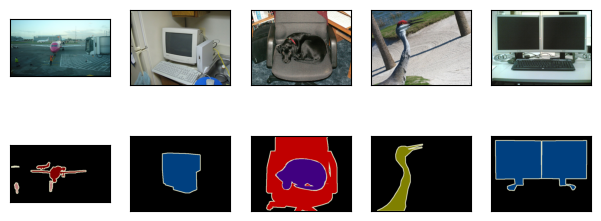

In [18]:
# plot the first 5 inputs images and their labels
n = 5
imgs = train_features[:n] + train_labels[:n]
# change to (height, width, # channels)
imgs = [img.permute(1, 2, 0) for img in imgs]

d2l.show_images(imgs, 2, n);

The black color represent the backround and the while represents the border of the object.

The RGB color values and class names for all the labels in this dataset are listed below.

In [19]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

We can define the `voc_colormap2label` function to build the mapping from the above RGB color values to class indices, and the `voc_label_indices` function ot map any RGB values to their class indices in the dataset.

In [20]:
def voc_colormap2label():
    '''Build the mapping from RGB to class indices for VOC labels'''
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)

    for i, colormap in enumerate(VOC_COLORMAP):
        # pixel indices
        idx = (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]
        # RGB -> class index
        colormap2label[idx] = i
    
    return colormap2label

def voc_label_indices(colormap, colormap2label):
    '''Map any RGB values in VOC labels to their class indices'''
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32') # change to (height, width, # channels)

    idx = (colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2]

    return colormap2label[idx]

In the first example image, the class index for the front part of the airplane is 1, while the background index is 0:

In [21]:
colormap2label = voc_colormap2label()
y = voc_label_indices(train_labels[0], colormap2label)
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

#### 14.9.2.1. Data Preprocessing

In semantic segmentation, if we resdcale the images to fit the model's required input shape, the label images also need to be rescaled to the same size as the input image. Such rescaling may be inaccurate, especially for segmented regions with different classes. To avoid this issue, we crop the image to a *fixed* shape instead of rescaling. Specifically, using random cropping from image augmentation, we crop the same area of the input image and the label.

In [22]:
def voc_rand_crop(feature, label, height, width):
    '''Randomly crop both feature and label images'''
    rect = torchvision.transforms.RandomCrop.get_params(img=feature, # image
                                                        output_size=(height, width)) # output size
    # crop feature image
    feature = torchvision.transforms.functional.crop(feature, *rect)
    # crop label image
    label = torchvision.transforms.functional.crop(label, *rect)

    return feature, label

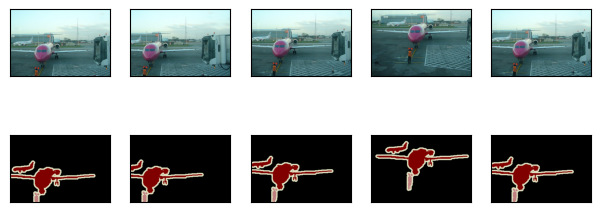

In [27]:
imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);
# imgs[::2] means from the first element to the last element, and step is 2
# imgs[1::2] means from the second element to the last element, and step is 2

#### 14.9.2.2. Custom Semantic Segmentation Dataset Class

In [33]:
class VOCSegDataset(torch.utils.data.Dataset):
    '''A customized dataset to load VOC dataset'''

    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], # RGB mean
            std=[0.229, 0.224, 0.225], # RGB standard deviation
        )
        self.crop_size = crop_size

        features, labels = read_voc_images(voc_dir, is_train=is_train)

        self.features = [self.normalize_image(feature) for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('Read ' + str(len(self.features)) + ' examples')


    def normalize_image(self, img):
        '''Normalize the image'''
        return self.transform(img.float() / 255)
    
    def filter(self, imgs):
        '''Filter out images whose width or height is less than crop size'''
        imgs_filtered = [
            img for img in imgs if (
                img.shape[1] >= self.crop_size[0] and
                img.shape[2] >= self.crop_size[1]
            )
        ]

        return imgs_filtered


    def __getitem__(self, idx):
        feature, label = voc_rand_crop(
            self.features[idx],
            self.labels[idx],
            *self.crop_size
        )
        return feature, voc_label_indices(label, self.colormap2label)
    
    def __len__(self):
        return len(self.features)

Since some images in the dataset have a smaller size than the output size of random cropping, these examples are filtered out by a custom `filter` function. In addition, the `normalize_image` is used to standardize the values of the three RGB channels of the input image.

#### 14.9.2.3. Reading the Dataset

In [34]:
crop_size = (320, 480)

voc_train = VOCSegDataset(is_train=True, crop_size=crop_size, voc_dir=voc_dir)
voc_test = VOCSegDataset(is_train=False, crop_size=crop_size, voc_dir=voc_dir)

Read 1114 examples
Read 1078 examples


In [35]:
batch_size = 64
# create a dataloader
train_iter = torch.utils.data.DataLoader(
    voc_train, # dataset
    batch_size, # batch size
    shuffle=True, # randomly shuffle the examples
    drop_last=True, # drop the last batch if it is not complete
    num_workers=d2l.get_dataloader_workers(), # number of subprocesses for reading data
)

for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

#### 14.9.2.4. Putting It All Together

In [ ]:
def load_data_voc(batch_size, crop_size):
    '''Load the VOC semantic segmentation dataset'''
    voc_dir = d2l.download_extract('voc2012',
                                   os.path.join('VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()

    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir),
        batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=num_workers
    )
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir),
        batch_size,
        drop_last=True,
        num_workers=num_workers
    )

    return train_iter, test_iter

In [ ]:
batch_size = 4
crop_size = (320, 480)

train_iter, test_iter = load_data_voc(batch_size, crop_size)

## 14.10. Transposed Convolution

In [1]:
import torch
from torch import nn

from d2l import torch as d2l

### 14.10.1. Basic Operation

Start with the basic transposed convolution operation with stride of 1 and no padding. Suppose that we are given a $n_h\times n_w$ input tensor and a $k_h\times k_w$ kernel. Sliding the kernel window with stride of 1 for $n_w$ times in each row and $n_h$ times in each column yields a total of $n_h n_w$ intermediate results. Each intermediate result is a $(n_h+k_h-1)\times (n_w+k_w-1)$ tensor that is initialized as zeros.

Each element in the input tensor is multiplied by the kernel so that the resulting $k_h\times k_w$ tensor replaces a portion in each intermediate tensor.

The figure below shows how transposed convolution with a $2\times 2$ kernel is computed for a $2\times 2$ input tensor.

![](../imgs/ch14/trans_conv.svg)

The `trans_conv` function is used to implement the above transposed convolution operation.

In [2]:
def trans_conv(X, K):
    h,w = K.shape
    Y = torch.zeros((X.shape[0] + h - 1,
                     X.shape[1] + w - 1))
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i : i+h, j : j+w] += X[i, j] * K

    return Y

In contrast to the regular convolution that *reduces* input elements via the kernel, the *transposed convolution broadcasts input elements* via the kernel, thereby producing an output that is larger than the input.

In [9]:
# same tensors in the figure above
X = torch.tensor([[0, 1], 
                  [2, 3]])
K = torch.tensor([[0, 1],
                  [2, 3]])

trans_conv(X, K)

tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]])

When the input `X` and the kernel `K` are both 4D tensors, the transposed convolution operation is applied to each input channel and output channel pair.

In [10]:
# reshape to (batch size, # channels, height, width)
X = X.reshape((1, 1) + X.shape).float()
K = K.reshape((1, 1) + K.shape).float()

# initialize a transposed convolutional layer
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, bias=False)
# assign the kernel of the convolutional layer
tconv.weight.data = K

tconv(X)

tensor([[[[ 0.,  0.,  1.],
          [ 0.,  4.,  6.],
          [ 4., 12.,  9.]]]], grad_fn=<ConvolutionBackward0>)

### 14.10.2. Padding, Strides, and Multiple Channels

Different from the regular convolution where padding is applied to the input, in the transposed convolution, it is applied to the output.

When specifying the padding number on either side of the height and width as 1, the first and last rows and columns will be removed from the transposed convolution output.

In [11]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, padding=1, bias=False)
tconv.weight.data = K

tconv(X)

tensor([[[[4.]]]], grad_fn=<ConvolutionBackward0>)

In [15]:
# compare with no padding
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, padding=0, bias=False)
tconv.weight.data = K

tconv(X)

tensor([[[[ 0.,  0.,  1.],
          [ 0.,  4.,  6.],
          [ 4., 12.,  9.]]]], grad_fn=<ConvolutionBackward0>)

In the transposed convolution, strides are specified for intermediate results (thus output), not for input. Using the same input and kernel tensors, changing the stride from 1 to 2 increases both the height and weight of intermediate tensors and the steps are shown in the figure below.

![](../imgs/ch14/trans_conv_stride2.svg)

In [16]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2, bias=False)
tconv.weight.data = K

tconv(X)

tensor([[[[0., 0., 0., 1.],
          [0., 0., 2., 3.],
          [0., 2., 0., 3.],
          [4., 6., 6., 9.]]]], grad_fn=<ConvolutionBackward0>)

For multiple input and output channels, the transposed convolution works in the same way as the regular convolution. Suppose that the input has $c_i$ channels, and that the transposed convolution assigns a $k_h\times k_w$ kernel tensor to each input channel. When multiple output channels are specified, we will have a $c_i\times k_h\times k_w$ kernel for each output channel.

In [17]:
# input tensor
X = torch.rand(size=(1, 10, 16, 16))
# convolutional layer
conv = nn.Conv2d(10, 20, kernel_size=5, padding=2, stride=3)
# transposed convolutional layer
tconv = nn.ConvTranspose2d(20, 10, kernel_size=5, padding=2, stride=3)

# conv -> tconv should be the identity mapping
tconv(conv(X)).shape

torch.Size([1, 10, 16, 16])

### 14.10.3. Connection to Matrix Transposition

We can implement convolution using matrix multiplications. Supposet have a $3\times 3$ input `X` and a $2\times 2$ convolution kernel `K`. We can use the `corr2d` function to compute the convolution output `Y`.

In [18]:
X = torch.arange(9.).reshape(3,3)
K = torch.tensor([[1, 2],
                  [3, 4]])

Y = d2l.corr2d(X, K) # 2D cross-correlation
Y

tensor([[27., 37.],
        [57., 67.]])

Then, we rewrite the convolution kernel `K` as a sparse weight matrix `W` containing a lot of zeros. The shape of the weight matrix is (4, 9), where the non-zero elements come from the convolution kernel `K`.

In [19]:
def kernel2matrix(K):
    k = torch.zeros(5)
    W = torch.zeros((4, 9))

    k[:2] = K[0, :]
    k[3:5] = K[1, :]

    W[0, :5] = k
    W[1, 1:6] = k
    W[2, 3:8] = k
    W[3, 4:] = k

    return W

In [20]:
W = kernel2matrix(K)
W

tensor([[1., 2., 0., 3., 4., 0., 0., 0., 0.],
        [0., 1., 2., 0., 3., 4., 0., 0., 0.],
        [0., 0., 0., 1., 2., 0., 3., 4., 0.],
        [0., 0., 0., 0., 1., 2., 0., 3., 4.]])

Concatenate the input `X` row by row to get a vector of length 9. Then the matrix multiplication of `W` and the vectorized `X` gives a vector of length 4. After reshaping it, we can obtain the same result `Y` from the original convolution operation above, by using matrix multiplication.

In [21]:
Y_mm = torch.mm(W, X.reshape(-1, 1)).reshape(2, 2)
Y_mm

tensor([[27., 37.],
        [57., 67.]])

In [22]:
Y_mm == Y

tensor([[True, True],
        [True, True]])

Likewise, we can implement transposed convolutions using matrix multiplications. We can take the $2\times 2$ output `Y` from the above regular convolution as input to the transposed convolution. We only need to transpose the weight matrix `W` with the new shape (9, 4).

In [28]:
Z = trans_conv(Y, K)
Z_mm = torch.mm(W.T, # transpose of W
                Y.reshape(-1, 1)).reshape(3, 3)
Z_mm == Z

tensor([[True, True, True],
        [True, True, True],
        [True, True, True]])

## 14.11. Fully Convolutional Networks (FCN)

*Semantic segmentation classifies images in pixel level.

A *fully convolutional network (FCN)* uses a convolutional neural network to transform image pixels to pixel classes. This FCN transforms the height and width of intermediate feature maps back to those of the input image. The classification output and the input image have a one-to-one correspondence in pixel level.

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F

from d2l import torch as d2l

### 14.11.1. The Model

The FCN first uses a CNN to extract image features, then transforms the number of channels into the number of classes via a $1\times 1$ convolutional layer, and finally transforms the height and width of the feature maps to those of the input image via the transposed convolution.

The model output has the same height and width as the input image, where the output channel contains the predicted classes for the input pixel at the same spatial position.

We can use a pretrained ResNet-18 model to extract image features and denote the model instance as `pretrained_net`. 

In [3]:
# load resnet18 weights
from torchvision.models import ResNet18_Weights
weights = ResNet18_Weights.DEFAULT

pretrained_net = torchvision.models.resnet18(weights=weights)

The last few layers of this model include a global average pooling layer and a fully connected layer.

In [4]:
list(pretrained_net.children())[-3:]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

We do not need those layers in FCN.

Then, we create a fully convolutional network instance `net`, which copies all the pretrained layers in the ResNet-18 except for the final global average pooling layer and the fully connected layer that are closest to the output.

In [5]:
net = nn.Sequential(
    *list(pretrained_net.children())[:-2]
)

Given an input wight height and width of 320 and 480, respectively, the forward propagation of `net` reduces the input height of width to 1/32 of the original, i.e., 10 and 15, respectively.

In [7]:
X = torch.rand(size=(1, 3, 320, 480))
# forward computation
net(X).shape

torch.Size([1, 512, 10, 15])

Next, we use a $1\times 1$ convolutional layer to transform the number of output channels into the number of classes of the Pascal VOC2012 dataset.

Finally, we need increase the height and width of the feature maps by 32 times to change them back to the same size as the input image. To calculate the output shape of a convolutional layer, we can compute the following equation:
\begin{aligned}
(320-64+16\times2+32)/32 &=10\\
(480-64+16\times2+32)/32 &=15
\end{aligned}
we need to construct a transposed convolutional layer with a stride of 32, kernel size of 64, and padding of 16.

In general, we can see that for stride $s$, padding $s/2$ (assuming $s/2$ is an integer), and kernel size $2s$, the transposed convolution will increase the height and width of the input by $s$ times.

In [8]:
num_classes = 21
# add a 1 x 1 convolutional layer
net.add_module(
    'final_conv',
    nn.Conv2d(512, num_classes, kernel_size=1),
)
# add a transposed convolutional layer
net.add_module(
    'transpose_conv',
    nn.ConvTranspose2d(
        num_classes, num_classes, kernel_size=64, padding=16, stride=32
    )
)

### 14.11.2. Initializing Transposed Convolutional Layers

To scale up an image, i.e., *upsampling*, the *bilinear interpolation* is one of the commonly used upsampling techniques.

Given an input image we want to calculate each pixel of the upsampled output image, in order to calculate the pixel of the output image at coordinate $(x,y)$, first map $(x,y)$ to coordinate $(x', y')$ on the input image, for example, according to the ratio of the input size to the output size.

Then, find the four pixels closest to coordinate $(x',y')$ on the input image. Finally, the pixel of the output image at coordinate $(x,y)$ is calculated based on these four closest pixels on the input image and their relative distances to $(x',y')$.

In [9]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2

    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5

    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    
    weight[range(in_channels), range(out_channels), :, :] = filt

    return weight

We can construct a transposed convolutional layer that doubles the height and weight, and initialize its kernel with the `bilinear_kernel` function:

In [10]:
conv_trans = nn.ConvTranspose2d(
    3, 3, kernel_size=4, padding=1, stride=2, bias=False
)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

Then, we read the image `X` and assign the upsampling output to `Y`.

In [11]:
img = torchvision.transforms.ToTensor()(d2l.Image.open('../imgs/ch14/catdogs.jpg'))
X = img.unsqueeze(0) # add batch dimension
Y = conv_trans(X)

out_img = Y[0].permute(1, 2, 0).detach() # change to (height, width, # channels)

Input image shape: torch.Size([2460, 4200, 3])
Output image shape: torch.Size([4920, 8400, 3])


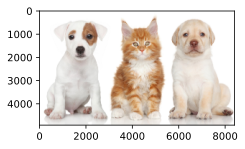

In [12]:
d2l.set_figsize()
print('Input image shape:', img.permute(1, 2, 0).shape)

d2l.plt.imshow(img.permute(1, 2, 0));

print('Output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

In a fully convolutional network, we initialize the transposed convolutional layer with upsampling of bilinear interpolation.

For the $1\times 1$ convolutional layer, we use the Xavier initialization method.

In [14]:
W = bilinear_kernel(num_classes, num_classes, 64)
# set the parameters of the transposed convolutional layer
net.transpose_conv.weight.data.copy_(W);

### 14.11.3. Reading the Dataset

In [15]:
batch_size = 32
crop_size = (320, 480)

train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


### 14.11.4. Training

Because we use the output channel of the transposed convolutional layer to predict the class for each pixel, the channel dimension is specified in the loss calculation. In addition, the accuracy is calculated based on correctness of the predicted class for all the pixels.

In [16]:
def loss(inputs, targets):
    # inputs: (batch size, number of classes, height, width)
    loss_full = F.cross_entropy(inputs, targets, reduction='none')
    # shape of `loss_full`: (batch size, number of classes, height, width)
    loss = loss_full.mean(1).mean(1)
    # shape of `loss`: (batch size,)
    return loss

In [17]:
num_epochs = 5
lr = 0.001
wd = 1e-3
devices = d2l.try_all_gpus()

trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)

loss 0.290, train acc 0.901, test acc 0.843
21.9 examples/sec on [device(type='cuda', index=0)]


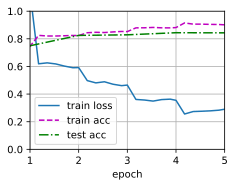

In [18]:
d2l.train_ch13(
    net,
    train_iter,
    test_iter,
    loss,
    trainer,
    num_epochs,
    devices
)

### 14.11.5. Prediction

When predicting, we need to standardize the input image in each channel and transform the image into the four-dimensional input format required by the CNN.

In [19]:
def predict(img):
    # normalize the image
    X = test_iter.dataset.normalize_image(img)
    # add batch dimension
    X = X.unsqueeze(0)

    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

In [20]:
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

Images in the test dataset vary in size and shape. Since the model uses a transposed convolutional layer with stride of 32, when the height or width of an input image is **indivisible** by 32, the output height or width of the transposed convolutional layer will deviate from the shape of the input image.

To address this issue, we can **crop multiple rectangular areas** with height and width that are integer multiples of 32 in the image, and perform forward propagation on the pixels in these areas separately. Then the union of these rectangular areas needs to completely cover the input image.

 When a pixel is covered by multiple rectangular areas, the average of the transposed convolution outputs in separate areas for this same pixel can be input to the softmax operation to predict the class for this pixel.

In [24]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)

n = 4
imgs = []
for i in range(n):
    # cropping rectangle
    crop_rect = (0, 0, 320, 480)
    # crop the image
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)

    pred = label2image(predict(X))
    imgs += [
        X.permute(1, 2 ,0), # original image
        pred.cpu(), # predicted label
        torchvision.transforms.functional.crop(test_labels[i], *crop_rect).permute(1, 2, 0) # ground truth label
    ]

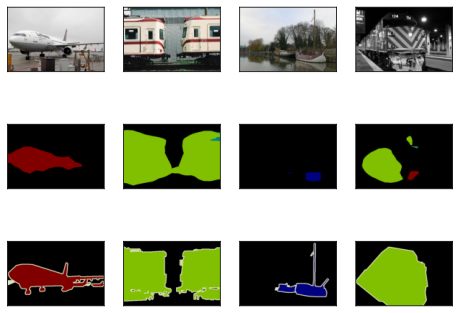

In [26]:
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

## 14.12. Neural Style Transfer

The *sytle transfer* task needs two input images: one is the *content image* and the other is the *style image*. We can use nerual networks to modify the content image to make it close to the style image in style.

### 14.12.1. Method

![](../imgs/ch14/neural-style.svg)

The figure above illustrates the CNN-based style transfer method. We initialize the synthesized image into the content image at first. This synthesized image is the only variable that needs to be updated during the style transfer process, i.e., the model parameters to be updated during training. Next, we choose a pretrained CNN to extract image features and freeze its model parameters during training. This deep CNN uses multiple layers to extract hierarchical features for images. We can choose the output of some of these layers as content features or style features.

In the figure above, if the pretrained neural network has 3 convolutional layers, we can choose the second layer as the content features and the first and third layers as the style features.

Then, we calculate the loss function of style transfer through forward propagation, and update the model parameters through backpropagation. The loss function of style transfer consists of three parts:
1. *content loss* makes the synthesized image and the content image close in content features;
2. *style loss* makes the synthesized image and style image close in style features; and
3. *total variation loss* helps reduce the noise in the synthesized image.

Finally, when the model training is done, we output the model parameters of the style transfer to generate the final synthesized image.

### 14.12.2. Reading the Content and Style Images

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn

from d2l import torch as d2l

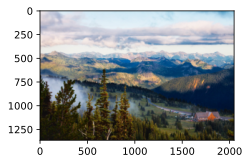

In [2]:
# plot the content image
d2l.set_figsize()
content_img = d2l.Image.open('../imgs/ch14/rainier.jpg')
d2l.plt.imshow(content_img);

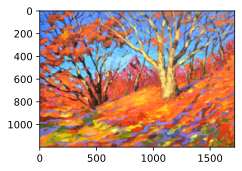

In [4]:
# plot the style image
style_img = d2l.Image.open('../imgs/ch14/autumn-oak.jpg')
d2l.plt.imshow(style_img);

### 14.12.3. Preprocessing and Postprocessing

We need a `preprocess` function to standarize each of the three RGB channels of the input image and transforms the results into the CNN input format.

In [5]:
# initialize the mean and std in the RGB channels
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

In [6]:
def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean,
                                         std=rgb_std)
    ])

    return transforms(img).unsqueeze(0) # add batch dimension

We also need a `postprocess` function to restore the pixel values in the output image to their original values before standardization.

In [7]:
def postprocess(img):
    # remove batch dimension and move the local device
    img = img[0].to(rgb_std.device)
    # move channels to the last dimension
    img = img.permute(1, 2, 0)
    # denormalize the image
    img = img * rgb_std + rgb_mean
    # clip the pixel values
    img = torch.clamp(img, 0, 1)
    # convert to the PIL image format
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

### 14.12.4. Extracting Features

We will use the VGG-19 model pretrained on the ImageNet dataset to extract image features.

In [8]:
# import vgg19 weights
from torchvision.models import VGG19_Weights
weights = VGG19_Weights.DEFAULT

pretrained_net = torchvision.models.vgg19(weights=weights)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\User/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100.0%


To extract the content features and style features of the image, we can select the output of certain layers in the VGG network.

Generally speaking, the closer to the input layer, the easier to extract details of the image, and vice versa, the easier to extract the global information of the image.

To avoid excessively retaining the details of the content image in the synthesized image, we choose a VGG layer that is closer to the output as the *content layer* to output the content features of the image. We also select the output of different VGG layers for extracting local and global style features. These layers are also called *style layers*.

In [10]:
print(pretrained_net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In Section 8.2, we know that the VGG network uses 5 convolutional blocks. Here, we choose the last convolutional layer of the fourth convolutional block as the content layer, and the first convolutional layer of each convolutional block as the style layers.

In [11]:
# select the output of the 4th convolutional block as the content feature
content_layer = [25]
# select the output of the 1st, 2nd, 3rd, 4th convolutional blocks as the style features
style_layers = [0, 5, 10, 19, 28]

When extracting features using VGG layers, we only need to use all those from the input layer to the content layer or style layer that is closest to the output layer. Here, we will construct a new network instance `net`, which only retains all the VGG layers to be used for feature extraction.

In [12]:
net = nn.Sequential(
    *[pretrained_net.features[i] for i in
      range(max(content_layer + style_layers) + 1)]
)

In [13]:
print(net)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Given the input `X`, if we invoke the forward propagation `net(X)`, we can only get the output of the last layer. Since we also need the outputs of intermediate layers, we need to perform **layer-by-layer** computation and keep the content and style layer outputs:

In [14]:
def extract_features(X, content_layer, style_layers):
    contents = []
    styles = []

    for i in range(len(net)):
        # forward computation of the current layer
        X = net[i](X)
        if i in style_layers:
            # extract the features of the current layer for the style image
            styles.append(X)
        if i in content_layer:
            # extract the features of the current layer for the content image
            contents.append(X)

    return contents, styles

We also need two helper functions:
* `get_contents` extracts content features from the content image; and
* `get_styles` extracts style features from the style image.

In [15]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layer, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layer, style_layers)
    return style_X, styles_Y

### 14.12.5. Defining the Loss Function

#### 14.12.5.1. Content Loss

Similar to the loss function in linear regression, the *content loss* measures the different in content features between the synthesized image and the content image via the squared loss function. The two inputs of the squared loss function are both outputs of the content layer computed by the `extract_features` function.

In [16]:
def content_loss(Y_hat, Y):
    # Need to detach the target content from the tree used to
    # dynamically compute the gradient.
    # This is a stated value, not a variable.
    # Otherwise the loss will throw an error.
    closs = torch.square(Y_hat - Y.detach()).mean()
    return closs

#### 14.12.5.2. Style Loss

Similar to the content loss, the *style loss* also uses the squared loss function to measure the difference in style between the synthesized image and the style image.

We first use the `extract_features` function to compute the style layer output. Suppose that the output has 1 example, $c$ channels, height $h$, and width $w$, then we can transform this output into matrix $\mathbf{X}$ with $c$ rows and $hw$ columns. This matrix $\mathbf{X}$ can be thought of as the concatenation of $c$ vectors $\mathbf{x}_1, \ldots, \mathbf{x}_c$, each of which has a length of $hw$, where the vector $\mathbf{x}_i$ represents the style feature of channel $i$.

In the *Gram matrix* of these vectors $\mathbf{X}\mathbf{X}^\top \in \mathbb{R}^{c \times c}$, the element $x_{ij}$ in row $i$ and column $j$ is the dot product of the vectors $\mathbf{x}_i$ and $\mathbf{x}_j$. It represents the correlation of the style features of channels $i$ and $j$. We use this Gram matrix to represent the style output of any style layer.

When the value of $hw$ is larger, it likely leads to larger values in the Gram matrix. The height and width of the Gram matrix are both the number of channels $c$. To allow style loss not to be affected by these values, the `gram` function below divides the Gram matrix by the number of its elements, i.e., $chw$.

In [17]:
def gram(X):
    # shape of X: (c, h, w)
    num_channels = X.shape[1] # c channels
    n = X.numel() // num_channels # n = h*w
    X = X.reshape((num_channels, n)) # shape: (c, h*w)
    return torch.matmul(X, X.T) / (num_channels * n)

The two Gram matrix inputs of the squared loss function for style loss are based on the style layer outputs for the synthesized image and the style image. It is assumed that the Gram matrix `gram_Y` based on the style image has been precomputed.

In [18]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

#### 14.12.5.3. Total Variation Loss

The learned synthesized image may has a lot of high-frequency noise, i.e., particularly bright or dark pixels. We can use the *total variation denoising* to reduce the noise.

Denote by $x_{i,j}$ the pixel value at coordinate $(i,j)$. Reducing total variation loss
\begin{split}
\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \left|x_{i, j} - x_{i, j+1}\right|
\end{split}
makes values of neighboring pixels on the synthesized image closer.

In [19]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                    torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

#### 14.12.5.4. Loss Function

The loss function of style transfer is the weighted sum of 
* content loss, 
* style loss, and 
* total variation loss. 

By adjusting these weight hyperparameters, we can balance among 
* content retention, 
* style transfer, and 
* noise reduction on the synthesized image.

In [20]:
content_weight = 1
style_weight = 1e4
tv_weight = 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # calculate the content loss
    contents_l = [
        content_loss(Y_hat, Y) * content_weight for Y_hat, Y in
        zip(contents_Y_hat, contents_Y)
    ]
    # calculate the style loss
    styles_l = [
        style_loss(Y_hat, Y) * style_weight for Y_hat, Y in
        zip(styles_Y_hat, styles_Y_gram)
    ]
    # calculate the total variation loss
    tv_l = tv_loss(X) * tv_weight

    # sum all the losses
    l = sum(styles_l + contents_l + [tv_l])

    # return the losses
    return contents_l, styles_l, tv_l, l

### 14.12.6. Initializing the Synthesized Image

In style transfer, the synthesized image is the only variable that needs to be updated during training. We need to define a simple model, `SynthesizedImage`, and treat the synthesized image as the model parameter.

In [21]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))  # weight parameter

    def forward(self):
        return self.weight

In [22]:
def get_inits(X, device, lr, styles_Y):
    # initialize the synthesized image
    gen_img = SynthesizedImage(X.shape).to(device)
    # set the parameter update rule
    gen_img.weight.data.copy_(X.data)

    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

The `get_inits` function creates a synthesized image model instance and initializes it to the image `X`. Gram matrices for the style image at various style layers, `styles_Y_gram`, are computed prior to trianing.

### 14.12.7. Training

When training the model for style transfer, we continuously extract content features and style features of the synthesized image, and calculate the loss function.

In [23]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    # initialize a learning scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    # create an animator
    animator = d2l.Animator(
        xlabel='epoch', ylabel='loss',
        xlim=[10, num_epochs],
        legend=['content', 'style', 'TV'],
        ncols=2, figsize=(7, 2.5)
    )

    for epoch in range(num_epochs):
        # zero out the gradients
        trainer.zero_grad()
        # extract the content and style features
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layer, style_layers
        )
        # calculate the loss
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram
        )
        # backpropagation
        l.backward()
        # update the synthesized image
        trainer.step()
        # update the learning rate
        scheduler.step()

        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)),
                                     float(tv_l)])
            
    return X

In [24]:
device = d2l.try_gpu()
image_shape = (320, 480) # PIL Image (h,w)

net = net.to(device)
# extract the content features
content_X, contents_Y = get_contents(image_shape, device)
# extract the style features
_, styles_Y = get_styles(image_shape, device)

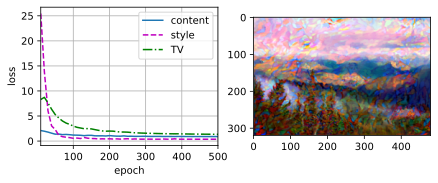

In [25]:
# train the model
output = train(
    X = content_X,
    contents_Y = contents_Y,
    styles_Y = styles_Y,
    device = device,
    lr = 0.3,
    num_epochs = 500,
    lr_decay_epoch = 50
)

We can see that the synthesized image retains the scenery and objects of the content image, and transfers the color of the style image at the same time.

## 14.13. Image Classification (CIFAR-10) ON Kaggle

In [26]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn

from d2l import torch as d2l

### 14.13.1. Obtaining and Organizing the Dataset

#### 14.13.1.1. Downloading the Dataset

In [27]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# set demo to False to download the full dataset
demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar10/'

#### 14.13.1.2. Organizing the Dataset

Need to read the labels from the csv file.

In [28]:
def read_csv_labels(fname):
    '''Read `fname` to return a filename to label dictionary'''
    with open(fname, 'r') as f:
        # skip the file header line (column name)
        lines = f.readlines()[1:]

    tokens = [l.rstrip().split(',') for l in lines]
    
    return dict(((name, label) for name, label in tokens))

In [29]:
labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# training examples:', len(labels))
print('# classes:', len(set(labels.values())))

# training examples: 1000
# classes: 10


The `reorg_train_valid` function splits the validation set out of the original training set.

In [34]:
def copyfile(filename, target_dir):
    '''Copy a file into a target directory'''
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
    '''Split the validation set out of the original training set'''
    # The number of examples of the class that has the fewest examples
    # in the training dataset
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # The number of examples per class for the validation set
    n_valid_per_label = max(1, math.floor(n * valid_ratio))

    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train_valid', label))

        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))

    return n_valid_per_label

If the `valid_ratio` is 0.1, then 90% of the images are used for trianing in the path `train_valid_test/train`, and the rest 10% are used for validation in the path `train_valid_test/valid`. After organizing the dataset, images of the same class will be placed under the same folder so that we can read them later.

The `reorg_test` function organizes the testing set for data loading during prediction.

In [31]:
def reorg_test(data_dir):
    '''Organize the testing set for data loading during prediction'''
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

The `reorg_cifar10_data` function invokes the `read_csv_labels`, `reorg_train_valid` and `reorg_test` functions to organize the CIFAR-10 dataset.

In [32]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

In [35]:
# batch size
batch_size = 32 if demo else 128 # 128 for full dataset
valid_ratio = 0.1

reorg_cifar10_data(data_dir, valid_ratio)

### 14.13.2. Image Augmentation

In [36]:
# Training images augmentation
transform_train = torchvision.transforms.Compose([
    # scale the image up to a square of 40 pixels in both height and width
    torchvision.transforms.Resize(40),
    # randomly crop a square image of 40 pixels in both height and width to
    # produce a small square of 0.64 to 1 times the area of the original image,
    # and then scale it to a square of 32 pixels in both height and width
    torchvision.transforms.RandomResizedCrop(size=32,
                                             scale=(0.64, 1),
                                             ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # standardize each channel of the image
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])
])

# Testing images augmentation
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])
])

### 14.13.3. Reading the Dataset

In [37]:
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_train
    ) for folder in ['train', 'train_valid']
]

valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_test
    ) for folder in ['valid', 'test']
]

During training, we need to specify all the image augmentation operations defined above.

When the validation set is used for model evaluation during hyperparameter tuning, no randomness from image augmentation should be introduced.

Before final prediction, we train the model on the combined training set and validation set to make full use of all the labeled data.

In [38]:
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(
        dataset,
        batch_size,
        shuffle=True,
        drop_last=True
    ) for dataset in (train_ds, train_valid_ds)
]

valid_iter = torch.utils.data.DataLoader(
    valid_ds,
    batch_size,
    shuffle=False,
    drop_last=True
)

test_iter = torch.utils.data.DataLoader(
    test_ds,
    batch_size,
    shuffle=False,
    drop_last=False
)

### 14.13.4. Defining the Model

We define the ResNet-18 model.

In [39]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes,
                       in_channels=3)
    return net

In [40]:
loss = nn.CrossEntropyLoss(reduction='none')

### 14.13.5. Defning the Training Function

We will select models and tune hyperparameters according to the model’s performance on the validation set.

In [41]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    # define the optimizer
    trainer = torch.optim.SGD(net.parameters(),
                              lr=lr,
                              momentum=0.9,
                              weight_decay=wd)
    # define the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(trainer,
                                                step_size=lr_period,
                                                gamma=lr_decay)
    num_batches = len(train_iter)
    timer = d2l.Timer()
    legend = ['train loss', 'train acc']

    if valid_iter is not None:
        legend.append('valid acc')

    # initialize an animator
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
        
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])

    for epoch in range(num_epochs):
        # training mode
        net.train()
        metric = d2l.Accumulator(3) # train_loss_sum, train_acc_sum, num_examples

        for i, (features, labels) in enumerate(train_iter):
            timer.start()

            l, acc = d2l.train_batch_ch13(
                net, features, labels, loss, trainer, devices
            )
            metric.add(l, acc, labels.shape[0])
            timer.stop()

            if (i+1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i+1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2], None))
                
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1,
                         (None, None, valid_acc))
            
        # update the learning rate
        scheduler.step()

    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}')

### 14.13.6. Training and Validating the Model

In [43]:
devices = d2l.try_all_gpus()
num_epochs = 20
lr = 2e-4
wd = 5e-4

lr_period = 10
lr_decay = 0.9

net = get_net()

net(next(iter(train_iter))[0]);

train loss 0.705, train acc 0.762, valid acc 0.438
255.3 examples/sec on [device(type='cuda', index=0)]


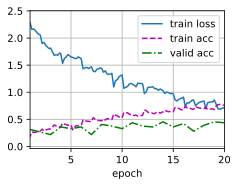

In [44]:
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

### 14.13.7. Classifying the Testing Set and Submitting Results on Kaggle

After obtaining a promising model with hyperparameters, we use all the labeled data (including the validation set) to retrain the model and classify the testing set.

train loss 0.659, train acc 0.758
252.5 examples/sec on [device(type='cuda', index=0)]


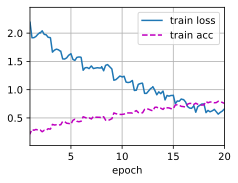

In [45]:
net = get_net()
preds = []

net(next(iter(train_valid_iter))[0]);

train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

In [ ]:
for X,_ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(
        y_hat.argmax(dim=1).type(torch.int32).cpu().numpy()
    )

sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))

df = pd.DataFrame(
    {'id': sorted_ids,
     'label':preds}
)

df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)

This generates a `submission.csv` file meeting the requirement of the Kaggle competition.

## 14.14. Dog Breed Identification (ImageNet Dogs) on Kaggle

In [46]:
import os
import torch
import torchvision
from torch import nn

from d2l import torch as d2l

### 14.14.1. Obtaining and Organizing the Dataset

#### 14.14.1.1. Downloading the Dataset

In [47]:
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip',
                            '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

# set demo to False to download the full dataset
demo = True

if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('../data', 'dog-breed-identification')

#### 14.14.1.2. Organizing the Dataset

The `reorg_dog_data` function reads the training data labels, splits out the validation set, and organizes the training set.

In [48]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))

    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)

In [49]:
batch_size = 32 if demo else 128
valid_ratio = 0.1

reorg_dog_data(data_dir, valid_ratio)

### 14.14.2. Image Augmentation

In [51]:
# training images augmentation
transform_train = torchvision.transforms.Compose([
    # Randomly crop the image to obtain an image with an area of 0.08 to 1 of
    # the original area and height to width ratio between 3/4 and 4/3.
    # Then scale the image to create a new 224 x 224 image
    torchvision.transforms.RandomResizedCrop(size=224,
                                             scale=(0.08, 1),
                                             ratio=(3/4, 4/3)),
    torchvision.transforms.RandomHorizontalFlip(),
    # Randomly change the brightness, contrast, and saturation
    torchvision.transforms.ColorJitter(brightness=0.4,
                                       contrast=0.4,
                                       saturation=0.4),
    torchvision.transforms.ToTensor(),
    # Standardize each channel of the image
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
])

# testing images augmentation
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    # crop a 224 x 224 square area from the center of image
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
])

### 14.14.3. Reading the Dataset

In [52]:
# create dataset instances
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_train
    ) for folder in ['train', 'train_valid']
]

valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_test
    ) for folder in ['valid', 'test']
]

In [53]:
# create dataloader instances
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(
        dataset,
        batch_size,
        shuffle=True,
        drop_last=True
    ) for dataset in (train_ds, train_valid_ds)
]

valid_iter = torch.utils.data.DataLoader(
    valid_ds,
    batch_size,
    shuffle=False,
    drop_last=True
)

test_iter = torch.utils.data.DataLoader(
    test_ds,
    batch_size,
    shuffle=False,
    drop_last=False
)

### 14.14.4. Fine-Tuning a Pretrained Model

Since this dataset is a subset of the ImageNet dataset, we can use a pretrained model trained on the ImageNet dataset to extract image features and use them to classify images in the dog breed identification dataset.

Here, we choose a pretrained ResNet-34 model and load its pretrained weights.

In [54]:
from torchvision.models import ResNet34_Weights
weights = ResNet34_Weights.DEFAULT

def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(weights=weights)

    # define a new output network (there are 120 output dog categories)
    finetune_net.output_new = nn.Sequential(
        nn.Linear(in_features=1000, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=120)
    )

    # move the model to devices
    finetune_net = finetune_net.to(devices[0])
    # freeze parameters of feature layers
    for param in finetune_net.features.parameters():
        param.requires_grad = False

    return finetune_net

Before calculating the loss, we first obtain the input of the pretrained model's output layer, i.e., the extracted feature. Then we use this feature as input for our small custom output network to calculate the loss.

In [55]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0

    for features, labels in data_iter:
        features = features.to(devices[0])
        labels = labels.to(devices[0])

        # forward computation
        outputs = net(features)
        # calculate the loss
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()

    return l_sum / n

### 14.14.5. Defining the Training Function

We will select the model and tune hyperparameters according to the model’s performance on the validation set. 

The `train` function only iterates parameters of the small custom output network.

In [56]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    # only train the small custom output network
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD(
        (param for param in net.parameters() if param.requires_grad),
        lr=lr,
        momentum=0.9,
        weight_decay=wd
    )
    scheduler = torch.optim.lr_scheduler.StepLR(trainer,
                                                step_size=lr_period,
                                                gamma=lr_decay)
    
    num_batches = len(train_iter)
    timer = d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2) # train_loss_sum, num_examples
        for i, (features, labels) in enumerate(train_iter):
            timer.start()

            features = features.to(devices[0])
            labels = labels.to(devices[0])

            # zero out the gradients
            trainer.zero_grad()
            # forward computation
            outputs = net(features)
            # calculate the loss
            l = loss(outputs, labels).sum()
            # backpropagation
            l.backward()
            # update the parameters
            trainer.step()

            metric.add(l, labels.shape[0])
            timer.stop()

            if (i+1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i+1) / num_batches,
                             (metric[0] / metric[1], None))
                
        measures = f'train loss {metric[0] / metric[1]:.3f}'

        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch+1,
                         (None, valid_loss.detach().cpu()))
            
        # update the learning rate
        scheduler.step()

    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}')

### 14.14.6. Training and Validating the Model

In [57]:
devices = d2l.try_all_gpus()
num_epochs = 10
lr = 1e-4
wd = 1e-4

lr_period = 2
lr_decay = 0.9

net = get_net(devices)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100.0%


train loss 1.047, valid loss 1.556
149.3 examples/sec on [device(type='cuda', index=0)]


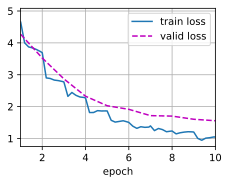

In [58]:
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

### 14.14.7. Classifying the Testing Set and Submitting Results on Kaggle

train loss 1.043
287.8 examples/sec on [device(type='cuda', index=0)]


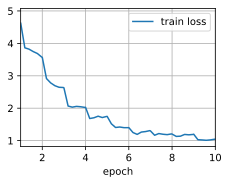

In [59]:
net = get_net(devices)

train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

In [60]:
preds = []
for data, label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=1)
    preds.extend(output.cpu().detach().numpy())

In [ ]:
ids = sorted(os.listdir(os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))

with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join([str(num) for num in output]) + '\n')